exit-velo-proj/
├─ src/
│  ├─ data/
│  │   └─ load_data.py        # load_raw()
│  ├─ features/
│  │   └─ preprocess.py       # preprocess(df) → df_clean
│  ├─ models/
│  │   ├─ baseline.py         # fit_mixed(), extract_empirical_bayes()
│  │   └─ hierarchical.py     # fit_bayesian_hierarchical(), posterior_predictive_draws()
│  └─ utils/
│      └─ helpers.py          # compute_league_prior(), estimate_noise_variance()


In [1]:
%%writefile src/data/load_data.py
import pandas as pd


def load_raw(path='data/Research Data Project/Research Data Project/exit_velo_project_data.csv'):
    """
    Load raw exit velocity data from the data directory.
    
    Returns:
        pd.DataFrame: Raw exit velocity data
    """
    # This is a placeholder - in a real implementation, you would load actual data
    # For example: df = pd.read_csv('data/raw/exit_velo.csv')

    df = pd.read_csv(path)
    return df 


if __name__ == "__main__":
    path = 'data/Research Data Project/Research Data Project/exit_velo_project_data.csv'
    df = load_raw(path)
    print(df.head())
    print(df.columns)

    # --- inspect nulls in the raw data ---
    null_counts = df.isnull().sum()
    null_counts = null_counts[null_counts > 0]
    if null_counts.empty:
        print("✅  No missing values in raw data.")
    else:
        print("=== Raw data null counts ===")
        for col, cnt in null_counts.items():
            print(f" • {col!r}: {cnt} missing")
    

Overwriting src/data/load_data.py


# Feature Engineering

In [2]:
%%writefile src/features/feature_engineering.py
"""Feature engineering utilities for the exit‑velo project.

All helpers are pure functions that take a pandas DataFrame and return a *copy*
with additional engineered columns so we avoid side effects.

Example
-------
>>> from src.data.load_data import load_raw
>>> from src.features.feature_engineering import feature_engineer
>>> df = load_raw()
>>> df_fe = feature_engineer(df)
"""
from __future__ import annotations

import pandas as pd
import numpy as np

###############################################################################
# Helper functions
###############################################################################

def _rolling_stat(
    df: pd.DataFrame,
    group_cols: list[str],
    target: str,
    stat: str = "mean",
    window: int = 50,
) -> pd.Series:
    """Group‑wise rolling statistic.  Sorted by season order of appearance.

    The function first sorts by the index order (assumed chronological inside each
    group) then applies a rolling window with *min_periods=10* so early samples
    are not overly noisy.
    """
    return (
        df.sort_values(group_cols)
        .groupby(group_cols)[target]
        .rolling(window, min_periods=10)
        .agg(stat)
        .reset_index(level=group_cols, drop=True)
    )

###############################################################################
# Public API
###############################################################################

def feature_engineer(df: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """Return a DataFrame enriched with engineered features.

    Parameters
    ----------
    df   : raw data as returned by ``load_raw``
    copy : if *True* (default) operate on a copy so the original is untouched.
    """

    if copy:
        df = df.copy()

    # ────────────────────────────────────────────────────────────────────────
    # 1. Basic type harmonisation & canonical casing
    # ────────────────────────────────────────────────────────────────────────
    str_cols = df.select_dtypes(include=['object', 'string']).columns
    df[str_cols] = df[str_cols].apply(lambda col: col.str.upper())

    # ────────────────────────────────────────────────────────────────────────
    # 2. Age engineering (dynamic quantile bins)
    # ────────────────────────────────────────────────────────────────────────
    df["age_sq"] = df["age"] ** 2  # capture non‑linear aging curve
    n_age_bins = 4
    df["age_bin"] = pd.qcut(df["age"], q=n_age_bins, duplicates='drop')
    
    # ────────────────────────────────────────────────────────────────────────
    # 3. Height normalisation relative to MLB average (~74 inches)
    # ────────────────────────────────────────────────────────────────────────
    df["height_diff"] = df["batter_height"] - 74

    # ────────────────────────────────────────────────────────────────────────
    # 4. Launch / spray angle buckets (dynamic quantile bins) & barrel indicator
    # ────────────────────────────────────────────────────────────────────────
    # Dynamic launch-angle bins
    n_la_bins = 5
    df["la_bin"] = pd.qcut(df["launch_angle"], q=n_la_bins, duplicates='drop')

    # Dynamic spray-angle bins
    n_spray_bins = 3
    df["spray_bin"] = pd.qcut(df["spray_angle"], q=n_spray_bins, duplicates='drop')

    # Statcast barrel proxy: EV >= 98 & 26° > LA >= 8°
    df["is_barrel"] = (
        (df["exit_velo"] >= 98) & (df["launch_angle"] >= 8) & (df["launch_angle"] < 26)
    ).astype("category")


    # ────────────────────────────────────────────────────────────────────────
    # 6. Handedness & matchup indicators
    # ────────────────────────────────────────────────────────────────────────
    df["same_hand"] = (df["batter_hand"] == df["pitcher_hand"])
    df["hand_match"] = df["batter_hand"] + "_VS_" + df["pitcher_hand"]

    # ────────────────────────────────────────────────────────────────────────
    # 7. Pitch‑type interactions
    # ────────────────────────────────────────────────────────────────────────
    df["pitch_hand_match"] = df["pitch_group"] + "_" + df["hand_match"]

    # ────────────────────────────────────────────────────────────────────────
    # 8. Player‑level historical stats (rolling EV mean & SD)
    #    These capture each hitter’s *latent* ability and shrink early samples
    #    via wider rolling windows.
    # ────────────────────────────────────────────────────────────────────────
    df["player_ev_mean50"] = _rolling_stat(df, ["batter_id"], "exit_velo", "mean", 50)
    df["player_ev_std50"] = _rolling_stat(df, ["batter_id"], "exit_velo", "std", 50)
    # ✱ NEW: safe assignment, no inplace chain ✱
    ev_mean_global = df["exit_velo"].mean()
    ev_std_global  = df["exit_velo"].std()
    df["player_ev_mean50"] = df["player_ev_mean50"].fillna(ev_mean_global)
    df["player_ev_std50"]  = df["player_ev_std50"].fillna(ev_std_global)

    # 9a. Hard‑hit & barrel‑adjacent flags
    df["hard_hit"] = (df["exit_velo"] >= 95).astype("category")
    df["near_barrel"] = (
        (df["exit_velo"].between(95, 98)) &
        (df["launch_angle"].between(5, 30))
    ).astype("category")

    # 9b. EV × LA and distance proxy
    df["ev_la_product"] = df["exit_velo"] * (df["launch_angle"] + 90)
    df["est_distance"] = df["exit_velo"] * df["hangtime"]
    #  Variance‑stabilised EV×LA
    df["ev_la_sqrt"] = np.sqrt(df["ev_la_product"].clip(lower=0))

    # 10. Pitcher rolling stats
    df["pitcher_ev_mean50"] = _rolling_stat(df, ["pitcher_id"], "exit_velo", "mean", 50)
    df["pitcher_ev_mean50"].fillna(df["exit_velo"].mean(), inplace=True)

    # 11. Outcome encoding – simple value mapping for power/speed signal.
    _OUTCOME_W = {
        "out": 0,
        "single": 1,
        "double": 2,
        "triple": 3,
        "home run": 4,
    }
    df["outcome_val"] = df["outcome"].str.lower().map(_OUTCOME_W)

    return df

###############################################################################
# CLI entry‑point (quick smoke test)
###############################################################################

if __name__ == "__main__":
    from pathlib import Path
    from src.data.load_data import load_raw

    raw_path = "data/Research Data Project/Research Data Project/exit_velo_project_data.csv"
    df = load_raw(raw_path)
    print(df.head())
    print(df.columns)

    # --- inspect nulls in the raw data ---
    null_counts = df.isnull().sum()
    null_counts = null_counts[null_counts > 0]
    if null_counts.empty:
        print("✅  No missing values in raw data.")
    else:
        print("=== Raw data null counts ===")
        for col, cnt in null_counts.items():
            print(f" • {col!r}: {cnt} missing")
    df_fe = feature_engineer(df)

    print("Raw →", df.shape, "//  Feature‑engineered →", df_fe.shape)
    print(df_fe.head())


Overwriting src/features/feature_engineering.py


# ColumnSchema: separates raw and engineered columns

In [3]:
%%writefile src/data/ColumnSchema.py
""" 
Column schema helper for exit‑velo project.

Centralises every raw and engineered column name in one place and exposes
 type‑safe accessors so downstream code never hard‑codes strings.

Usage
-----
>>> from src.features.columns import cols
>>> num_cols = cols.numerical()
>>> ord_cols = cols.ordinal()
>>> all_for_model = cols.model_features()
"""

from functools import lru_cache
from typing import List, Dict
import json

class _ColumnSchema:
    """Container for canonical column lists.

    Keeping everything behind methods avoids accidental mutation and lets
    IDEs offer autocompletion (because the return type is always `List[str]`).
    """

    _ID_COLS: List[str] = [
        "season", "batter_id", "pitcher_id",
    ]

    _ORDINAL_CAT_COLS: List[str] = [
        "level_abbr",   # AA < AAA < MLB
        "age_bin",      # 4 quantile bins of age
        "la_bin",       # 5 quantile bins of launch angle
        "spray_bin",    # 3 quantile bins of spray angle
        "outcome_val",  # 0–4 mapping of out→HR
    ]

    _NOMINAL_CAT_COLS: List[str] = [
        "hit_type",
        "outcome",
        "pitch_group",
        "batter_hand",
        "pitcher_hand",
        "hand_match",
        "pitch_hand_match",
        "same_hand",
        "is_barrel",
        "hard_hit",
        "near_barrel",
    ]

    _NUMERICAL_COLS: List[str] = [
        # raw inputs
        "exit_velo",
        "launch_angle",
        "spray_angle",
        "hangtime",
        # engineered continuous
        "ev_la_product",
        "ev_la_sqrt",
        "est_distance",
        "player_ev_mean50",
        "player_ev_std50",
        "pitcher_ev_mean50",
    ]

    _TARGET_COL: str = "exit_velo"

    # ────────────────────────────────────────────────────────────────────
    # Public helpers
    # ────────────────────────────────────────────────────────────────────
    def id(self) -> List[str]:
        return self._ID_COLS.copy()

    def ordinal(self) -> List[str]:
        return self._ORDINAL_CAT_COLS.copy()

    def nominal(self) -> List[str]:
        return self._NOMINAL_CAT_COLS.copy()

    def categorical(self) -> List[str]:
        """All cat cols (ordinal + nominal)."""
        return self._ORDINAL_CAT_COLS + self._NOMINAL_CAT_COLS

    def numerical(self) -> List[str]:
        return self._NUMERICAL_COLS.copy()


    def target(self) -> str:
        return self._TARGET_COL

    # ------------------------------------------------------------------
    @lru_cache(maxsize=1)
    def model_features(self) -> List[str]:
        """Columns fed into the ML pipeline *after* preprocess.

        Excludes the target but includes derived cols.
        """
        phys_minus_target = [
            c for c in self._NUMERICAL_COLS if c != self._TARGET_COL
        ]

        return (
            phys_minus_target
            + self._NOMINAL_CAT_COLS
            + self._ORDINAL_CAT_COLS  # some algos want raw string order
        )

    def all_raw(self) -> List[str]:
        """Returns every column expected in raw input CSV (incl. engineered)."""
        return (
            self._ID_COLS
            + self._ORDINAL_CAT_COLS
            + self._NOMINAL_CAT_COLS
            + self._NUMERICAL_COLS
        )

    def as_dict(self) -> Dict[str, List[str]]:
        """Dictionary form – handy for YAML/JSON dumps."""
        return {
            "id": self.id(),
            "ordinal": self.ordinal(),
            "nominal": self.nominal(),
            "numerical": self.numerical(),
            "target": [self.target()],
        }


if __name__ == "__main__":
    # singleton instance people can import as `cols`
    cols = _ColumnSchema()

    __all__ = ["cols"]
    print("ID columns:         ", cols.id())
    print("Ordinal columns:    ", cols.ordinal())
    print("Nominal columns:    ", cols.nominal())
    print("All categorical:    ", cols.categorical())
    print("Numerical columns:  ", cols.numerical())
    print("Target column:      ", cols.target())
    print("Model features:     ", cols.model_features())
    print("All raw columns:    ", cols.all_raw())
    print("\nAs dict (JSON):")
    print(json.dumps(cols.as_dict(), indent=2))



Overwriting src/data/ColumnSchema.py


   season level_abbr  batter_id  pitcher_id  exit_velo  launch_angle  \
0    2023        mlb        235        1335    95.7352       47.2362   
1    2023        mlb       3182        1335    95.9380        4.7291   
2    2023        mlb       3856        1988    89.1404      -16.2251   
3    2023        mlb       2017        1988    88.7278       -6.8385   
4    2023        mlb       1594        1988    89.2888        0.5079   

   spray_angle  hangtime     hit_type batter_hand pitcher_hand  batter_height  \
0      -6.4422    6.4960     fly_ball           R            R             72   
1      -4.8052    0.7806  ground_ball           L            R             75   
2      15.2382    0.0311  ground_ball           S            R             72   
3     -11.5988    0.1215  ground_ball           R            R             69   
4     -22.1899    0.3802  ground_ball           R            R             73   

  pitch_group outcome   age  
0          FB     out  32.8  
1          OS     ou

c:\docker_projects\Marlins_Data_Science_Project\src\features\feature_engineering.py:133: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["pitcher_ev_mean50"].fillna(df["exit_velo"].mean(), inplace=True)


Raw → (1344651, 15) //  Feature‑engineered → (1344651, 33)
   season level_abbr  batter_id  pitcher_id  exit_velo  launch_angle  \
0    2023        MLB        235        1335    95.7352       47.2362   
1    2023        MLB       3182        1335    95.9380        4.7291   
2    2023        MLB       3856        1988    89.1404      -16.2251   
3    2023        MLB       2017        1988    88.7278       -6.8385   
4    2023        MLB       1594        1988    89.2888        0.5079   

   spray_angle  hangtime     hit_type batter_hand  ... pitch_hand_match  \
0      -6.4422    6.4960     FLY_BALL           R  ...        FB_R_VS_R   
1      -4.8052    0.7806  GROUND_BALL           L  ...        OS_L_VS_R   
2      15.2382    0.0311  GROUND_BALL           S  ...        OS_S_VS_R   
3     -11.5988    0.1215  GROUND_BALL           R  ...        BB_R_VS_R   
4     -22.1899    0.3802  GROUND_BALL           R  ...        FB_R_VS_R   

   player_ev_mean50 player_ev_std50 hard_hit  near_barrel

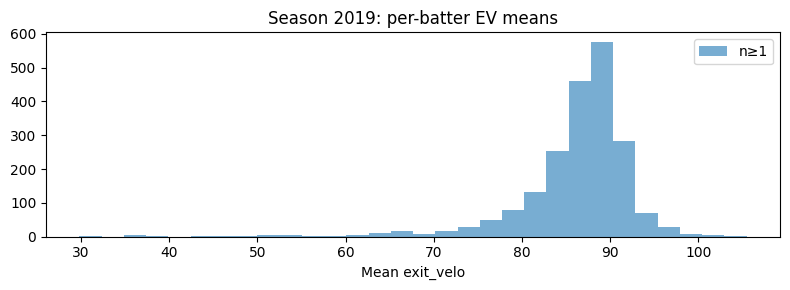


=== Season 2020 (cutoff = 4) ===
  small (<4 events): 26 batters
           count        mean        std
count  26.000000   26.000000  17.000000
mean    2.076923   84.458086  10.871630
std     0.890980   12.043159   5.095985
min     1.000000   52.750300   2.336493
25%     1.000000   78.336112   7.482416
50%     2.000000   87.500092  11.224181
75%     3.000000   91.412875  14.257916
max     3.000000  103.927000  18.257835 

  large (≥4 events): 551 batters
            count        mean         std
count  551.000000  551.000000  551.000000
mean    83.747731   87.432446   14.387383
std     57.932091    3.861183    2.891105
min      4.000000   69.071725    3.653479
25%     31.000000   85.400928   12.859783
50%     75.000000   87.847618   14.230645
75%    130.000000   89.845474   15.569497
max    236.000000  101.994967   30.101003


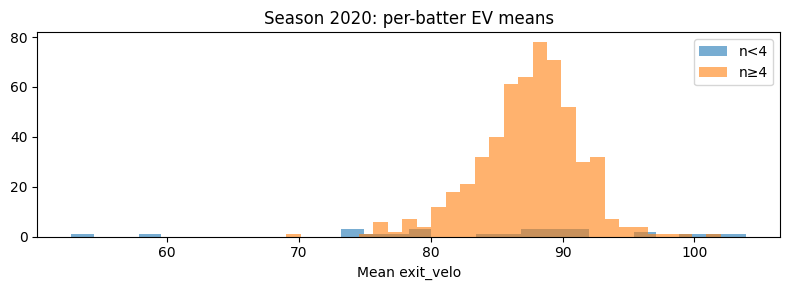


=== Season 2021 (cutoff = 1) ===
  small (<1 events): 24 batters
       count  mean  std
count   24.0   0.0  0.0
mean     0.0   NaN  NaN
std      0.0   NaN  NaN
min      0.0   NaN  NaN
25%      0.0   NaN  NaN
50%      0.0   NaN  NaN
75%      0.0   NaN  NaN
max      0.0   NaN  NaN 

  large (≥1 events): 2094 batters
             count         mean          std
count  2094.000000  2094.000000  1916.000000
mean    134.526743    84.214960    15.338418
std     125.289860     9.831129     5.045620
min       1.000000    15.840100     0.201738
25%      14.000000    83.341614    13.234280
50%     113.500000    86.781967    14.494073
75%     218.000000    89.052564    16.079132
max     573.000000   109.563500    49.195823


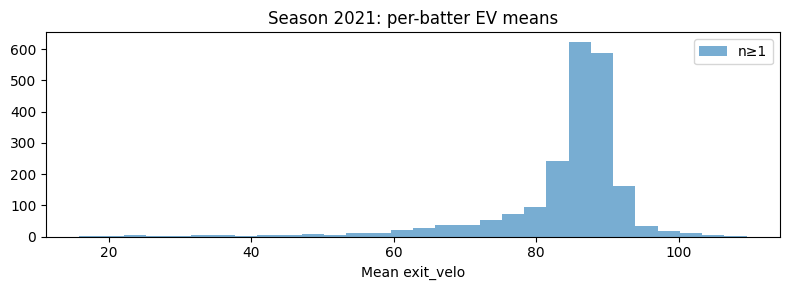


=== Season 2022 (cutoff = 7) ===
  small (<7 events): 76 batters
           count        mean        std
count  76.000000   75.000000  50.000000
mean    2.710526   84.652919  13.619921
std     1.742150   11.322603   7.533067
min     0.000000   43.179000   0.138381
25%     1.000000   78.693950   9.023225
50%     2.000000   85.248620  12.770922
75%     4.000000   92.238350  16.088318
max     6.000000  106.930600  34.319286 

  large (≥7 events): 1558 batters
             count         mean          std
count  1558.000000  1558.000000  1558.000000
mean    191.661104    87.613310    14.344330
std     120.742551     3.238958     2.008355
min       7.000000    67.084514     3.993811
25%      92.250000    85.813300    13.154436
50%     185.000000    87.880013    14.168904
75%     271.000000    89.654535    15.365575
max     547.000000    99.508492    24.509298


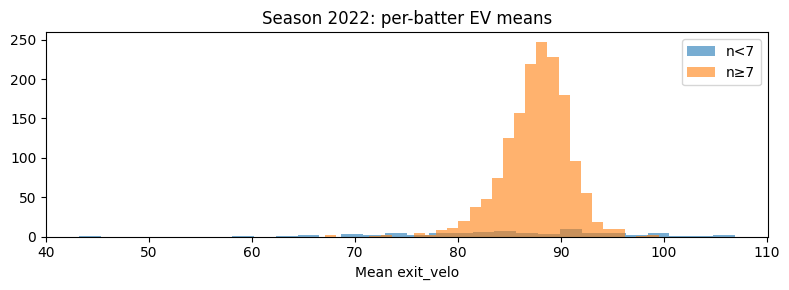


=== Season 2023 (cutoff = 8) ===
  small (<8 events): 81 batters
           count        mean        std
count  81.000000   81.000000  60.000000
mean    3.604938   83.938957  14.905462
std     2.131191   10.070824   8.034139
min     1.000000   57.794150   0.601536
25%     1.000000   76.816400   8.629504
50%     3.000000   84.646300  12.444107
75%     6.000000   91.019100  18.948647
max     7.000000  103.122400  41.759922 

  large (≥8 events): 1548 batters
             count         mean          std
count  1548.000000  1548.000000  1548.000000
mean    208.377907    87.586954    14.467978
std     123.600258     3.023750     1.996144
min       8.000000    70.225789     7.043703
25%     107.000000    85.856681    13.265147
50%     203.000000    87.748473    14.279267
75%     295.000000    89.598690    15.413339
max     626.000000    97.649865    28.693296


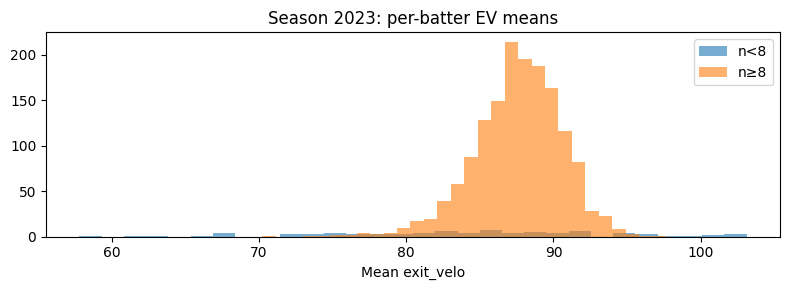


=== Season 2019 (cutoff = 15) ===
  small (<15 events): 658 batters
            count        mean         std
count  658.000000  578.000000  416.000000
mean     3.901216   82.083698   13.568049
std      3.733631   11.225885    7.547931
min      0.000000   29.830300    0.426880
25%      1.000000   77.601813    8.597501
50%      2.000000   83.613206   12.292912
75%      6.000000   89.399650   17.307435
max     14.000000  105.458200   47.678937 

  large (≥15 events): 1482 batters
             count         mean          std
count  1482.000000  1482.000000  1482.000000
mean    198.739541    87.688582    13.518924
std     117.373983     3.225415     1.748771
min      15.000000    66.604795     7.766006
25%     100.250000    85.905727    12.434321
50%     200.000000    88.077001    13.340243
75%     285.000000    89.829129    14.325163
max     529.000000    96.982189    25.417163


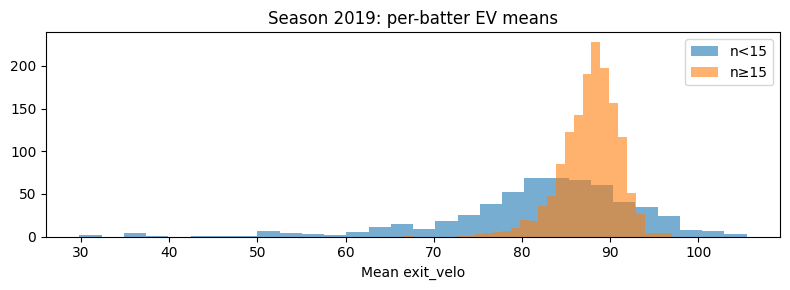


=== Season 2020 (cutoff = 15) ===
  small (<15 events): 96 batters
           count        mean        std
count  96.000000   96.000000  87.000000
mean    6.583333   86.162420  12.963285
std     3.862551    8.182201   5.444868
min     1.000000   52.750300   2.336493
25%     3.000000   81.373948   9.306805
50%     6.000000   87.179571  12.030724
75%     9.250000   91.666961  15.859450
max    14.000000  103.927000  30.101003 

  large (≥15 events): 481 batters
            count        mean         std
count  481.000000  481.000000  481.000000
mean    94.733888   87.525147   14.520707
std     53.778557    3.396287    2.276787
min     15.000000   74.999825    7.628236
25%     47.000000   85.645571   13.089276
50%     91.000000   87.897929   14.304017
75%    138.000000   89.765934   15.550161
max    236.000000   95.930653   24.423458


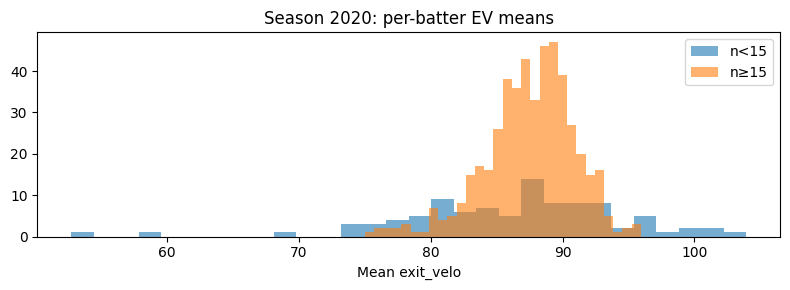


=== Season 2021 (cutoff = 15) ===
  small (<15 events): 555 batters
            count        mean         std
count  555.000000  531.000000  353.000000
mean     4.048649   77.152960   17.326599
std      3.826019   15.940760    9.951699
min      0.000000   15.840100    0.201738
25%      1.000000   69.830904   10.079698
50%      3.000000   79.595313   16.445516
75%      6.000000   87.448559   24.334643
max     14.000000  109.563500   49.195823 

  large (≥15 events): 1563 batters
             count         mean          std
count  1563.000000  1563.000000  1563.000000
mean    178.792067    86.614142    14.889392
std     115.312889     4.535739     2.792587
min      15.000000    53.684787     7.857596
25%      86.000000    85.256269    13.375624
50%     167.000000    87.332750    14.443432
75%     250.000000    89.210932    15.618886
max     573.000000    95.902174    33.952330


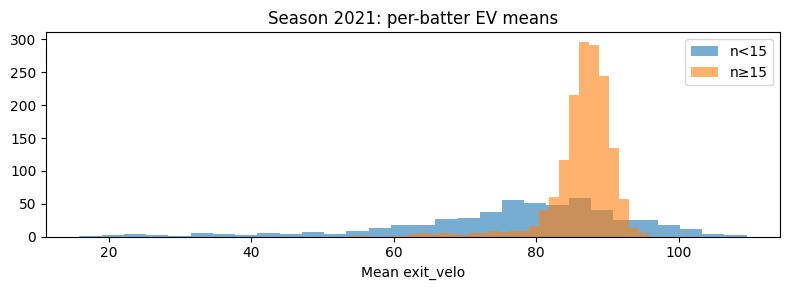


=== Season 2022 (cutoff = 15) ===
  small (<15 events): 130 batters
            count        mean         std
count  130.000000  129.000000  104.000000
mean     5.923077   85.307396   13.837819
std      4.318009    9.452014    6.014305
min      0.000000   43.179000    0.138381
25%      2.000000   79.844480   10.343767
50%      5.000000   85.679740   13.358057
75%      9.000000   91.616075   16.859504
max     14.000000  106.930600   34.319286 

  large (≥15 events): 1504 batters
             count         mean          std
count  1504.000000  1504.000000  1504.000000
mean    198.167553    87.663465    14.355272
std     117.813987     3.090252     1.883928
min      15.000000    67.106207     8.779188
25%     105.000000    85.892411    13.199632
50%     189.000000    87.907399    14.168904
75%     275.000000    89.625325    15.330585
max     547.000000    99.508492    24.509298


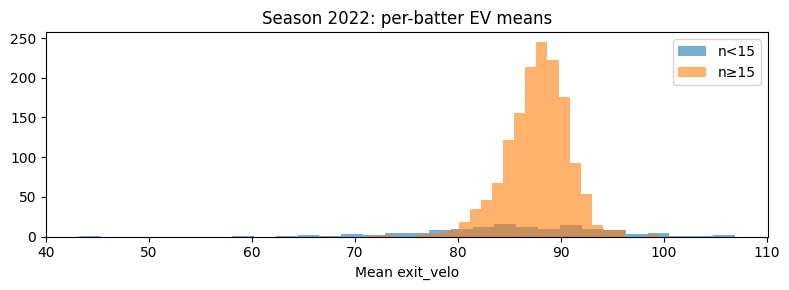


=== Season 2023 (cutoff = 15) ===
  small (<15 events): 120 batters
            count        mean        std
count  120.000000  120.000000  99.000000
mean     6.166667   84.354106  15.032218
std      4.278799    8.850238   6.988167
min      1.000000   57.794150   0.601536
25%      3.000000   78.494097  10.223130
50%      5.500000   85.152333  13.943609
75%      9.250000   89.861316  18.751162
max     14.000000  103.122400  41.759922 

  large (≥15 events): 1509 batters
             count         mean          std
count  1509.000000  1509.000000  1509.000000
mean    213.466534    87.648222    14.448356
std     121.010417     2.908334     1.850884
min      15.000000    73.745590     7.043703
25%     118.000000    85.929218    13.284772
50%     206.000000    87.785425    14.279371
75%     298.000000    89.609844    15.398784
max     626.000000    97.649865    24.019631


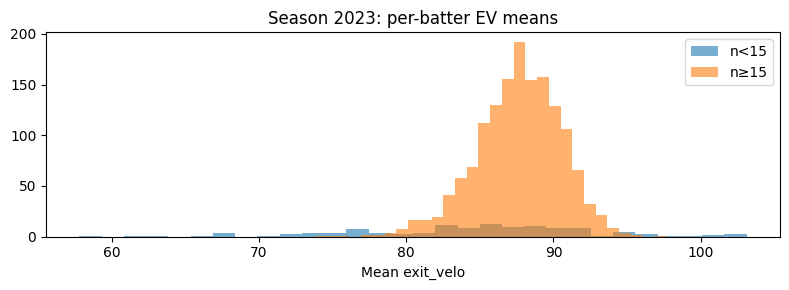


===== NULLS CHECK =====
Columns with null values: ['exit_velo', 'launch_angle', 'spray_angle', 'hangtime', 'hit_type', 'la_bin', 'spray_bin', 'ev_la_product', 'est_distance', 'ev_la_sqrt', 'outcome_val']

===== QUICK PULSE CHECK =====
                      Metric        Value
                  Total rows 1.344651e+06
              Unique batters 3.715000e+03
           Overall median EV 9.083820e+01
              Median EV @ AA 9.045200e+01
             Median EV @ AAA 9.062115e+01
             Median EV @ MLB 9.124190e+01
Events per batter (25th pct) 1.300000e+01
  Events per batter (median) 1.850000e+02
    Batters with 1 season(s) 1.642000e+03
    Batters with 2 season(s) 8.650000e+02
    Batters with 3 season(s) 5.050000e+02
    Batters with 4 season(s) 3.040000e+02
    Batters with 5 season(s) 3.990000e+02
  ρ(exit_velo, launch_angle) 1.393828e-01
      ρ(exit_velo, hangtime) 1.517460e-01

===== RED FLAGS CHECK =====
> Batters with fewer than 15 events: 957
  First few: 3742, 397

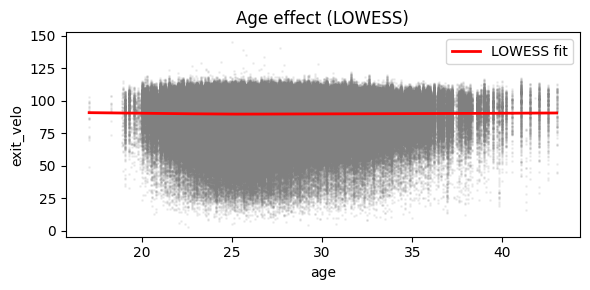

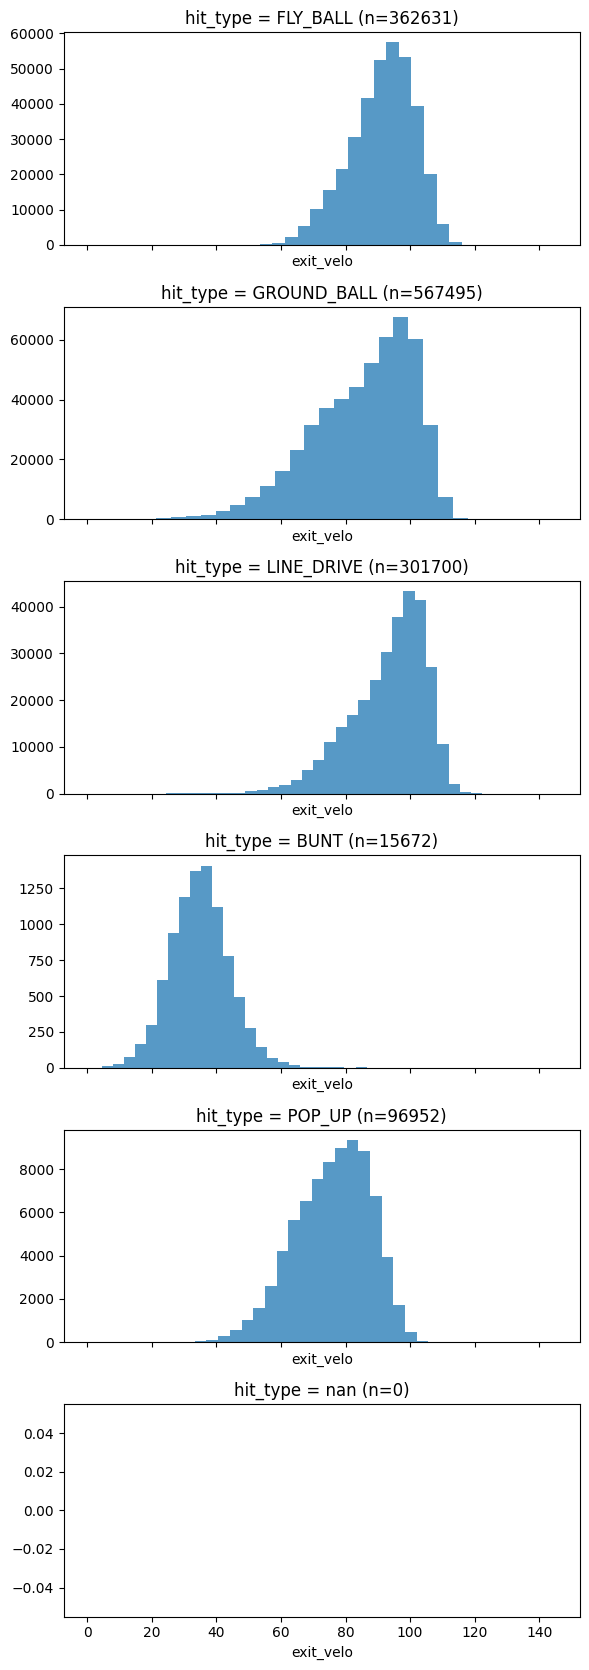

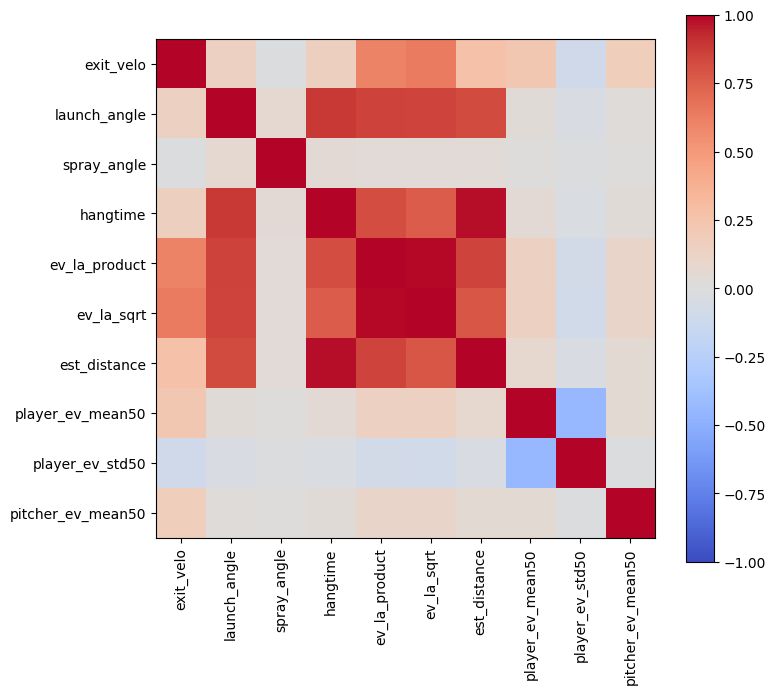

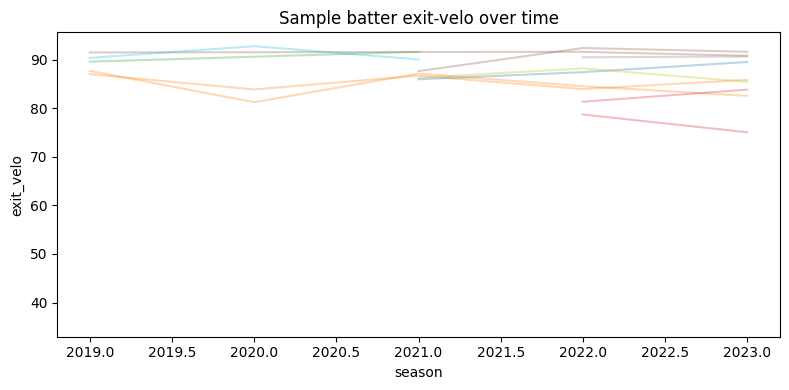

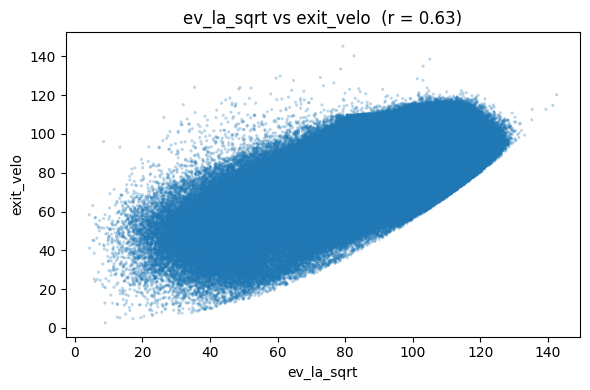

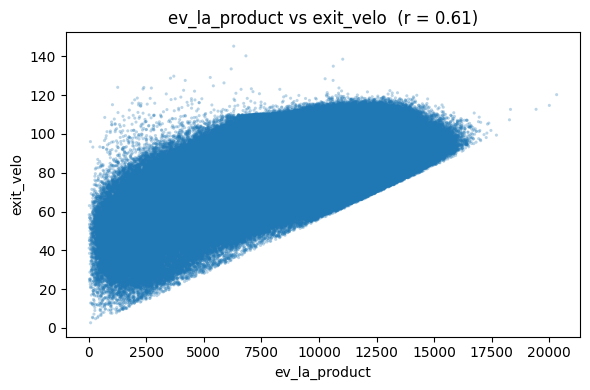

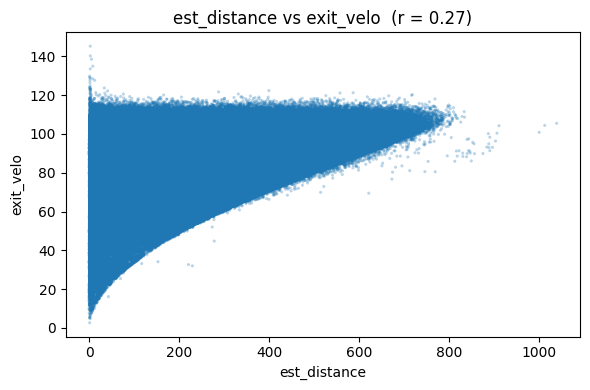

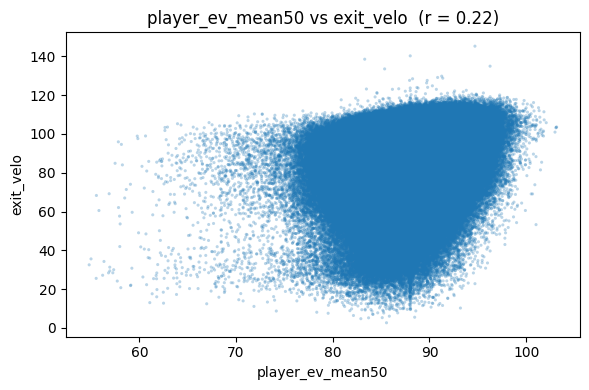

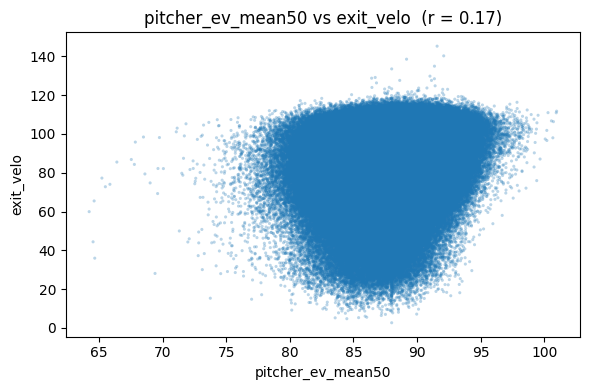

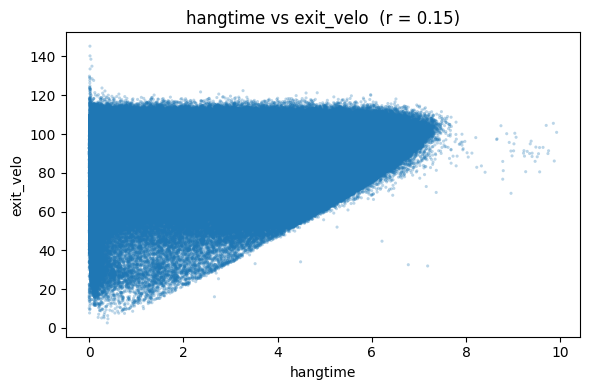

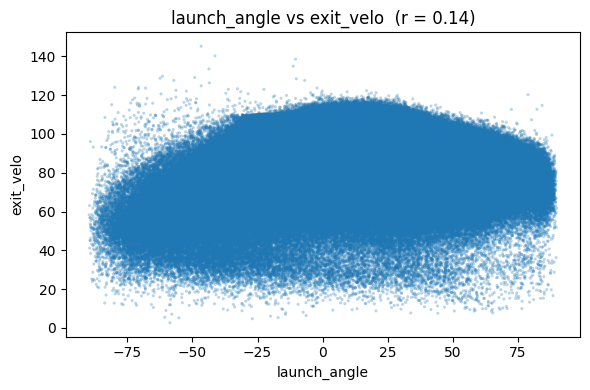

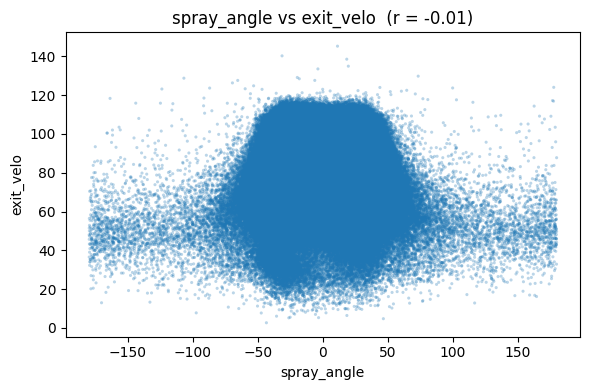

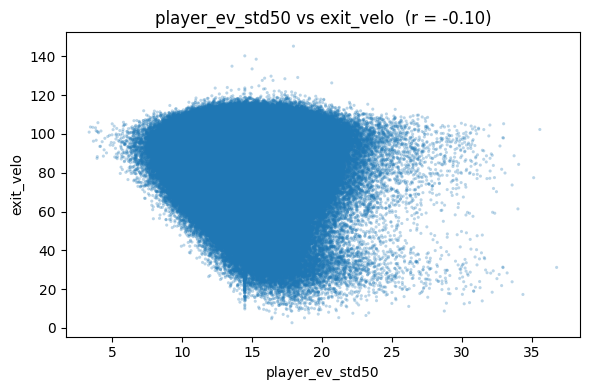

In [4]:
# %%writefile src/features/eda.py
# src/features/eda.py

import pandas as pd  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import numpy as np  # type: ignore
from src.data.ColumnSchema import _ColumnSchema

# Optional imports with fallbacks for advanced statistics
try:
    import scipy.stats as stats  # type: ignore
    from statsmodels.nonparametric.smoothers_lowess import (
        lowess  # type: ignore
    )
    from statsmodels.stats.stattools import (
        durbin_watson  # type: ignore
    )
    _HAS_STATS_LIBS = True
except ImportError:
    _HAS_STATS_LIBS = False
    print("Warning: scipy or statsmodels not available. "
          "Some diagnostics will be limited.")


def get_column_groups() -> dict:
    """
    Return a mapping of column-type → list of columns,
    based on the canonical schema in src.features.feature_selection.cols.
    """
    return cols.as_dict()

def check_nulls(df: pd.DataFrame):
    # Identify columns with null values
    null_columns = df.columns[df.isnull().any()].tolist()
    
    # Output the columns with null values
    if null_columns:
        print("Columns with null values:", null_columns)
    else:
        print("No columns with null values.")


def quick_pulse_check(
    df: pd.DataFrame,
    velo_col: str = "exit_velo",
    group_col: str = "batter_id",
    level_col: str = "level_abbr"
) -> pd.DataFrame:
    """
    Print a quick summary table:
      - total rows
      - unique batters
      - overall median exit_velo
      - median exit_velo by level
      - distribution of events per batter (median, 25th pct)
      - distribution of seasons per batter
      - pearson correlations of velo with launch_angle & hangtime
    Returns a pd.DataFrame with those metrics.
    """
    df = df.copy()
    total_rows = len(df)
    n_batters = df[group_col].nunique()
    overall_med = df[velo_col].median()

    # median by level
    med_by_level = df.groupby(level_col)[velo_col].median()

    # events per batter
    ev_per = df[group_col].value_counts()
    ev_stats = ev_per.quantile([0.25, 0.5]).to_dict()

    # seasons per batter
    seasons_per = df.groupby(group_col)["season"].nunique()
    seasons_stats = seasons_per.value_counts().sort_index().to_dict()

    # basic correlations
    corr = df[[velo_col, "launch_angle", "hangtime"]].corr()[velo_col].drop(velo_col)

    # Build a summary table
    metrics = [
        "Total rows",
        "Unique batters",
        "Overall median EV",
    ]
    values = [
        total_rows,
        n_batters,
        overall_med,
    ]
    
    # Add level-specific metrics
    for lvl in med_by_level.index:
        metrics.append(f"Median EV @ {lvl}")
        values.append(med_by_level[lvl])
    
    # Add batter event metrics
    metrics.extend([
        "Events per batter (25th pct)",
        "Events per batter (median)",
    ])
    values.extend([
        ev_stats.get(0.25, "N/A"),
        ev_stats.get(0.5, "N/A"),
    ])
    
    # Add season distribution
    for season_count, count in seasons_stats.items():
        metrics.append(f"Batters with {season_count} season(s)")
        values.append(count)
    
    # Add correlations
    metrics.extend([
        "ρ(exit_velo, launch_angle)",
        "ρ(exit_velo, hangtime)",
    ])
    values.extend([
        corr.get("launch_angle", "N/A"),
        corr.get("hangtime", "N/A"),
    ])

    table = pd.DataFrame({
        "Metric": metrics,
        "Value": values
    })
    
    print(table.to_string(index=False))
    return table


def red_flag_small_samples(df: pd.DataFrame,
                           group_col: str = "batter_id",
                           threshold: int = 15) -> pd.Series:
    """
    Identify batters with fewer than `threshold` events.
    Returns a Series of counts indexed by batter_id.
    """
    counts = df[group_col].value_counts()
    small = counts[counts < threshold]
    print(f"> Batters with fewer than {threshold} events: {len(small)}")
    if len(small) > 0:
        print(f"  First few: {', '.join(map(str, small.index[:5]))}")
    return small


def red_flag_level_effect(df: pd.DataFrame,
                          level_col: str = "level_abbr",
                          velo_col: str = "exit_velo") -> tuple:
    """
    One-way ANOVA of exit_velo across levels.
    Returns (F-statistic, p-value) or (None, None) if scipy is not available.
    """
    if not _HAS_STATS_LIBS:
        print("> ANOVA on exit_velo by level: scipy not available")
        print("> Basic level summary instead:")
        summary = df.groupby(level_col)[velo_col].agg(['mean', 'std', 'count'])
        print(summary)
        return None, None
    
    groups = [
        df[df[level_col] == lvl][velo_col].dropna()
        for lvl in df[level_col].unique()
    ]
    F, p = stats.f_oneway(*groups)
    print(f"> ANOVA on {velo_col} by {level_col}: F={F:.3f}, p={p:.3e}")
    return F, p


def diag_age_effect(df: pd.DataFrame,
                    age_col: str = "age_centered",
                    velo_col: str = "exit_velo") -> np.ndarray | None:
    """
    LOWESS smoothing of exit_velo vs. age_centered.
    Returns the smoothed array or None if statsmodels is not available.
    """
    if not _HAS_STATS_LIBS:
        print("> Age effect analysis: statsmodels not available")
        print("> Basic correlation instead:")
        corr = df[[age_col, velo_col]].corr().iloc[0, 1]
        print(f"Correlation between {age_col} and {velo_col}: {corr:.3f}")
        return None
    
    # Run LOWESS smoothing
    smooth_result = lowess(df[velo_col], df[age_col])
    
    # Plot the result
    plt.figure(figsize=(6, 3))
    plt.scatter(df[age_col], df[velo_col], alpha=0.1, s=1, color='gray')
    plt.plot(
        smooth_result[:, 0], 
        smooth_result[:, 1], 
        'r-', 
        linewidth=2, 
        label="LOWESS fit"
    )
    plt.xlabel(age_col)
    plt.ylabel(velo_col)
    plt.title("Age effect (LOWESS)")
    plt.legend()
    plt.tight_layout()
    
    return smooth_result


def diag_time_series_dw(
    df: pd.DataFrame,
    time_col: str = "season",
    group_col: str = "batter_id",
    velo_col: str = "exit_velo"
) -> pd.Series | None:
    """
    Compute Durbin–Watson on each batter's time series of mean exit_velo.
    Returns a Series of DW statistics or None if statsmodels is not available.
    """
    if not _HAS_STATS_LIBS:
        print("> Time series analysis: statsmodels not available")
        return None
    
    # Create pivot table of seasons (columns) by batters (rows)
    pivot = (
        df
        .groupby([group_col, time_col])[velo_col]
        .mean()
        .unstack(fill_value=np.nan)
    )
    
    # Only process batters with at least 3 seasons
    valid_batters = pivot.dropna(thresh=3).index
    if len(valid_batters) == 0:
        print("> No batters with sufficient seasons for Durbin-Watson test")
        return None
    
    # Calculate DW statistic for each valid batter
    dw_stats = {}
    for batter in valid_batters:
        series = pivot.loc[batter].dropna()
        if len(series) >= 3:  # Recheck after dropna
            dw = durbin_watson(series)
            dw_stats[batter] = dw
    
    dw_series = pd.Series(dw_stats)
    print(
        f"> Mean Durbin–Watson across {len(dw_series)} batters: "
        f"{dw_series.mean():.3f}"
    )
    print("> DW < 1.5 suggests positive autocorrelation")
    print("> DW > 2.5 suggests negative autocorrelation")
    print("> DW ≈ 2.0 suggests no autocorrelation")
    
    return dw_series


def check_red_flags(df: pd.DataFrame, 
                    sample_threshold: int = 15) -> dict:
    """
    Run all red flag checks and return the results in a dictionary.
    """
    results = {}
    
    # Check for small sample sizes
    small_samples = red_flag_small_samples(df, threshold=sample_threshold)
    results['small_samples'] = small_samples
    
    # Check for level effects
    f_stat, p_val = red_flag_level_effect(df)
    results['level_effect'] = {
        'f_statistic': f_stat,
        'p_value': p_val
    }
    
    return results


def plot_distributions(df: pd.DataFrame,
                       velo_col: str = "exit_velo",
                       by: str = "level_abbr"):
    """
    Histogram of `velo_col` faceted by `by`.
    Returns the Matplotlib figure so callers can save or show it.
    """
    groups = df[by].unique()
    fig, axes = plt.subplots(len(groups), 1,
                             figsize=(6, 2.8 * len(groups)),
                             sharex=True)
    for ax, grp in zip(axes, groups):
        ax.hist(df[df[by] == grp][velo_col], bins=30, alpha=0.75)
        ax.set_title(f"{by} = {grp} (n={len(df[df[by] == grp])})")
        ax.set_xlabel(velo_col)
    fig.tight_layout()
    return fig


def plot_correlations(df: pd.DataFrame, cols: list[str]):
    """
    Heat-map of Pearson correlations for `cols`.
    """
    corr = df[cols].corr()
    fig, ax = plt.subplots(figsize=(0.6 * len(cols) + 2,
                                    0.6 * len(cols) + 2))
    im = ax.imshow(corr, vmin=-1, vmax=1, cmap="coolwarm")
    fig.colorbar(im, ax=ax, shrink=0.8)
    ax.set_xticks(range(len(cols)), cols, rotation=90)
    ax.set_yticks(range(len(cols)), cols)
    fig.tight_layout()
    return fig


def plot_time_trends(df: pd.DataFrame,
                     time_col: str = "season",
                     group_col: str = "batter_id",
                     velo_col: str = "exit_velo",
                     sample: int = 50):
    """
    Plot mean exit-velo over time for a random sample of batters.
    """
    batters = df[group_col].unique()
    chosen = np.random.choice(batters,
                              min(sample, len(batters)),
                              replace=False)
    fig, ax = plt.subplots(figsize=(8, 4))
    for b in chosen:
        series = (
            df[df[group_col] == b]
            .groupby(time_col)[velo_col]
            .mean()
        )
        ax.plot(series.index, series.values, alpha=0.3)
    ax.set_xlabel(time_col)
    ax.set_ylabel(velo_col)
    ax.set_title("Sample batter exit-velo over time")
    fig.tight_layout()
    return fig


def summarize_numeric_vs_target(
    df: pd.DataFrame,
    numeric_cols: list[str] | None = None,
    target_col: str = "exit_velo",
) -> pd.DataFrame:
    """
    Summarise each numeric predictor against the target.

    Returns a DataFrame indexed by feature with:
      n          – number of non‑null pairs
      pearson_r  – Pearson correlation coefficient
    """
    # --- Pull fresh lists from the schema every time -----------------
    groups = cols.as_dict()

    if numeric_cols is None:
        numeric_cols = groups.get("numerical", [])

    # --- Clean the list ---------------------------------------------
    numeric_cols = [
        c for c in numeric_cols
        if c != target_col and c in df.columns      # ❶ exclude target, ❷ guard
    ]

    records = []
    for col in numeric_cols:
        sub = df[[col, target_col]].dropna()
        if sub.empty:               # skip columns that are all‑NA
            continue
        r = sub[col].corr(sub[target_col])
        records.append({"feature": col, "n": len(sub), "pearson_r": r})

    result = (
        pd.DataFrame.from_records(records)
        .set_index("feature")
        .sort_values("pearson_r", ascending=False)
    )

    print("\n=== Numeric vs target correlations ===")
    print(result)

    return result


def plot_numeric_vs_target(
    df: pd.DataFrame,
    numeric_cols: list[str] | None = None,
    target_col: str = "exit_velo",
):
    """
    Scatter plots of each numeric predictor vs the target with r‑value in title.
    """
    summary = summarize_numeric_vs_target(df, numeric_cols, target_col)
    for feature, row in summary.iterrows():
        plt.figure(figsize=(6, 4))
        plt.scatter(
            df[feature], df[target_col],
            alpha=0.3, s=5, edgecolors="none"
        )
        plt.title(f"{feature} vs {target_col}  (r = {row['pearson_r']:.2f})")
        plt.xlabel(feature)
        plt.ylabel(target_col)
        plt.tight_layout()
        plt.show()



def summarize_categorical_vs_target(
    df: pd.DataFrame,
    cat_cols: list[str] | None = None,
    target_col: str = "exit_velo"
) -> dict[str, pd.DataFrame]:
    """
    For each categorical feature, returns a DataFrame of:
      count, mean, median, std of the target by category.
    """
    groups = get_column_groups()
    if cat_cols is None:
        cat_cols = groups.get("categorical", [])

    summaries: dict[str, pd.DataFrame] = {}
    for col in cat_cols:
        stats = (
            df
            .groupby(col)[target_col]
            .agg(count="count", mean="mean", median="median", std="std")
            .sort_values("count", ascending=False)
        )
        print(f"\n=== {col} vs {target_col} summary ===")
        print(stats)
        summaries[col] = stats
    return summaries


def plot_categorical_vs_target(
    df: pd.DataFrame,
    cat_cols: list[str] | None = None,
    target_col: str = "exit_velo"
):
    """
    For each categorical feature, draw a box‑plot of the target by category.
    """
    groups = get_column_groups()
    if cat_cols is None:
        cat_cols = groups.get("categorical", [])

    for col in cat_cols:
        plt.figure(figsize=(6, 4))
        df.boxplot(column=target_col, by=col, vert=False,
                   grid=False, patch_artist=True)
        plt.title(f"{target_col} by {col}")
        plt.suptitle("")           # remove pandas' automatic suptitle
        plt.xlabel(target_col)
        plt.tight_layout()
        plt.show()



def examine_and_filter_by_sample_size(
    df: pd.DataFrame,
    count_col: str = "exit_velo",
    group_col: str = "batter_id",
    season_col: str = "season",
    percentile: float = 0.05,
    min_count: int | None = None,
    filter_df: bool = False,
) -> tuple[dict[int, pd.DataFrame], pd.DataFrame | None]:
    """
    For each season:
      - compute per-batter count, mean, std of `count_col`
      - pick cutoff: min_count if provided, else the `percentile` quantile
      - print diagnostics
      - plot histograms *safely* (drops NaNs first)
    Returns:
      - summaries: dict season → per-batter summary DataFrame
      - filtered_df: if filter_df, the original df filtered to batters ≥ cutoff
    """
    summaries: dict[int, pd.DataFrame] = {}
    mask_keep: list[pd.Series] = []

    for season, sub in df.groupby(season_col):
        # 1) per-batter summary (count *non-NA* exit_velo)
        summary = (
            sub
            .groupby(group_col)[count_col]
            .agg(count="count", mean="mean", std="std")
            .sort_values("count")
        )
        summaries[season] = summary

        # 2) determine cutoff
        cutoff = min_count if min_count is not None else int(summary["count"].quantile(percentile))
        small = summary[summary["count"] < cutoff]
        large = summary[summary["count"] >= cutoff]

        # 3) diagnostics
        print(f"\n=== Season {season} (cutoff = {cutoff}) ===")
        print(f"  small (<{cutoff} events): {len(small)} batters")
        print(small[["count","mean","std"]].describe(), "\n")
        print(f"  large (≥{cutoff} events): {len(large)} batters")
        print(large[["count","mean","std"]].describe())

        # 4) **safe plotting**: drop NaNs, skip if nothing to plot
        small_means = small["mean"].dropna()
        large_means = large["mean"].dropna()

        if small_means.empty and large_means.empty:
            print(f"  ⚠️  Season {season}: no valid per-batter means to plot")
        else:
            plt.figure(figsize=(8, 3))
            if not small_means.empty:
                plt.hist(small_means, bins=30, alpha=0.6, label=f"n<{cutoff}")
            if not large_means.empty:
                plt.hist(large_means, bins=30, alpha=0.6, label=f"n≥{cutoff}")
            plt.title(f"Season {season}: per-batter EV means")
            plt.xlabel("Mean exit_velo")
            plt.legend()
            plt.tight_layout()
            plt.show()

        # 5) build mask to keep only large-sample batters
        if filter_df:
            keep_ids = large.index
            mask_keep.append(
                (df[season_col] == season) &
                (df[group_col].isin(keep_ids))
            )

    # 6) combine masks and filter
    filtered_df = None
    if filter_df and mask_keep:
        combined = pd.concat(mask_keep, axis=1).any(axis=1)
        filtered_df = df[combined].copy()

    return summaries, filtered_df




if __name__ == "__main__":
    from pathlib import Path
    from src.data.load_data import load_raw
    from src.features.feature_engineering import feature_engineer

    raw_path = "data/Research Data Project/Research Data Project/exit_velo_project_data.csv"
    df = load_raw(raw_path)
    print(df.head())
    print(df.columns)

    # --- inspect nulls in the raw data ---
    null_counts = df.isnull().sum()
    null_counts = null_counts[null_counts > 0]
    if null_counts.empty:
        print("✅  No missing values in raw data.")
    else:
        print("=== Raw data null counts ===")
        for col, cnt in null_counts.items():
            print(f" • {col!r}: {cnt} missing")
    df_fe = feature_engineer(df)

    print("Raw →", df.shape, "//  Feature‑engineered →", df_fe.shape)
    print(df_fe.head())

    # singleton instance people can import as `cols`
    cols = _ColumnSchema()

    __all__ = ["cols"]
    print("ID columns:         ", cols.id())
    print("Ordinal columns:    ", cols.ordinal())
    print("Nominal columns:    ", cols.nominal())
    print("All categorical:    ", cols.categorical())
    print("Numerical columns:  ", cols.numerical())
    print("Model features:     ", cols.model_features())
    print("Target columns:  ", cols.target())
    print("All raw columns:    ", cols.all_raw())
    numericals = cols.numerical()
    # use list‐comprehension to drop target(s) from numerical features
    numericals_without_y = [c for c in numericals if c not in cols.target()]


    print("\n===== check on small samples =====")
    summaries, _ = examine_and_filter_by_sample_size(df, percentile=0.05)
    summaries, df_filtered = examine_and_filter_by_sample_size(
        df, percentile=0.05, min_count=15, filter_df=False
    )

    
    # Example usage
    print("\n===== NULLS CHECK =====")
    check_nulls(df_fe)
    
    print("\n===== QUICK PULSE CHECK =====")
    quick_pulse_check(df_fe)
    
    print("\n===== RED FLAGS CHECK =====")
    check_red_flags(df_fe)
    
    print("\n===== AGE EFFECT ANALYSIS =====")
    diag_age_effect(df_fe, age_col="age")
    
    print("\n===== TIME SERIES ANALYSIS =====")
    diag_time_series_dw(df_fe)
    
    print("\n===== PLOTTING =====")
    fig1 = plot_distributions(df_fe, by="hit_type")
    fig2 = plot_correlations(df_fe, numericals)  # Using cols schema
    fig3 = plot_time_trends(df_fe, sample=20)


    # — Numeric features —
    num_summary = summarize_numeric_vs_target(df_fe)
    plot_numeric_vs_target(df_fe)

    # — Categorical features —
    cat_summary = summarize_categorical_vs_target(df_fe)
    plot_categorical_vs_target(df_fe)



# Data exploration and P value fix /normalize and anything else needed

In [5]:
%%writefile src/features/feature_normalization.py



if __name__ == "__main__":
    from pathlib import Path
    from src.data.load_data import load_raw
    from src.features.feature_engineering import feature_engineer

    raw_path = "data/Research Data Project/Research Data Project/exit_velo_project_data.csv"
    df = load_raw(raw_path)
    print(df.head())
    print(df.columns)

    # --- inspect nulls in the raw data ---
    null_counts = df.isnull().sum()
    null_counts = null_counts[null_counts > 0]
    if null_counts.empty:
        print("✅  No missing values in raw data.")
    else:
        print("=== Raw data null counts ===")
        for col, cnt in null_counts.items():
            print(f" • {col!r}: {cnt} missing")
    df_fe = feature_engineer(df)

    print("Raw →", df.shape, "//  Feature‑engineered →", df_fe.shape)
    print(df_fe.head())

    # singleton instance people can import as `cols`
    cols = _ColumnSchema()

    __all__ = ["cols"]
    print("ID columns:         ", cols.id())
    print("Ordinal columns:    ", cols.ordinal())
    print("Nominal columns:    ", cols.nominal())
    print("All categorical:    ", cols.categorical())
    print("Numerical columns:  ", cols.numerical())
    print("Model features:     ", cols.model_features())
    print("Target columns:  ", cols.target())
    print("All raw columns:    ", cols.all_raw())
    numericals = cols.numerical()
    # use list‐comprehension to drop target(s) from numerical features
    numericals_without_y = [c for c in numericals if c not in cols.target()]
    





Overwriting src/features/feature_normalization.py


# Preprocessing

In [17]:
%%writefile src/features/preprocess.py
"""
Preprocessing module for exit velocity pipeline.
Supports multiple model types (linear, XGBoost, PyMC, etc.) with
automatic ordinal-category detection from the data.
"""
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from src.data.ColumnSchema import _ColumnSchema
from sklearn.model_selection import train_test_split

from pandas.api.types import is_categorical_dtype
# ───────────────────────────────────────────────────────────────────────
# Numeric & nominal pipelines (unchanged)
# ───────────────────────────────────────────────────────────────────────
numeric_linear = Pipeline([
    ('impute', SimpleImputer(strategy='median', add_indicator=True)),
    ('scale', StandardScaler()),
])
numeric_iterative = Pipeline([
    ('impute', IterativeImputer(random_state=0, add_indicator=True)),
    ('scale', StandardScaler()),
])
nominal_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('encode', OneHotEncoder(drop='first', handle_unknown='ignore')),
])

# ───────────────────────────────────────────────────────────────────────
# Dynamic preprocess functions
# ───────────────────────────────────────────────────────────────────────
# src/features/preprocess.py

def fit_preprocessor(
    df: pd.DataFrame,
    model_type: str = "linear",
    debug: bool = False,
) -> tuple[np.ndarray, pd.Series, ColumnTransformer]:
    """
    Build & fit the preprocessing ColumnTransformer on the *full* training data.
    Returns (X_matrix, y, fitted_transformer).
    """
    cols = _ColumnSchema()
    TARGET = cols.target()

    # ------------------------------------------------------------
    # 1. filter rows & coerce numerics
    # ------------------------------------------------------------
    df = df[df["hit_type"].str.upper() != "BUNT"].copy()
    df = df.dropna(subset=[TARGET])
    num_feats = [c for c in cols.numerical() if c != TARGET]
    df[num_feats] = df[num_feats].apply(pd.to_numeric, errors="coerce")

    # engineered auxiliaries
    df["age_centered"] = df["age"] - df["age"].median()
    df["level_idx"] = df["level_abbr"].map({"AA": 0, "AAA": 1, "MLB": 2})

    # ------------------------------------------------------------
    # 2. Prepare X, y as DATAFRAMES (keeps column names)
    # ------------------------------------------------------------
    ord_feats = cols.ordinal()
    nom_feats = cols.nominal()
    X = df[num_feats + ord_feats + nom_feats]
    y = df[TARGET]

    # force all ordinal columns to string so categories are comparable
    X[ord_feats] = (
        X[ord_feats]
        .astype(str)
        .where(X[ord_feats].notna(), other=np.nan)  # keep NaNs
    )

    # ------------------------------------------------------------
    # 3. Compute *global* ordinal category lists
    # ------------------------------------------------------------
    ordinal_categories = []
    for c in ord_feats:
        cats = (
            X[c].dropna().unique().tolist()
        )
        if "MISSING" not in cats:
            cats.append("MISSING")
        ordinal_categories.append(cats)

    if debug:
        print("Detected ordinal categories:", list(zip(ord_feats, ordinal_categories)))

    # ------------------------------------------------------------
    # 4. Build pipelines
    # ------------------------------------------------------------
    ordinal_pipe = Pipeline(
        [
            ("impute", SimpleImputer(strategy="constant", fill_value="MISSING")),
            (
                "encode",
                OrdinalEncoder(
                    categories=ordinal_categories,
                    handle_unknown="use_encoded_value",
                    unknown_value=-1,
                    dtype="int32",
                ),
            ),
        ]
    )

    numeric_pipe = (
        numeric_linear if model_type == "linear" else numeric_iterative
    )

    ct = ColumnTransformer(
        [
            ("num", numeric_pipe, num_feats),
            ("ord", ordinal_pipe, ord_feats),
            ("nom", nominal_pipe, nom_feats),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )

    X_mat = ct.fit_transform(X, y)  # still returns a NumPy array
    return X_mat, y, ct




def transform_preprocessor(
    df: pd.DataFrame,
    transformer: ColumnTransformer,
) -> tuple[np.ndarray, pd.Series]:
    """
    Apply an already‑fitted transformer to *any* new DataFrame.
    Unseen ordinal categories are coerced to 'MISSING' first.
    """
    cols = _ColumnSchema()
    TARGET = cols.target()
    num_feats = [c for c in cols.numerical() if c != TARGET]
    ord_feats = cols.ordinal()
    nom_feats = cols.nominal()

    df = df.dropna(subset=[TARGET]).copy()
    df[num_feats] = df[num_feats].apply(pd.to_numeric, errors="coerce")
    df["age_centered"] = df["age"] - df["age"].median()
    df["level_idx"] = df["level_abbr"].map({"AA": 0, "AAA": 1, "MLB": 2})

    X = df[num_feats + ord_feats + nom_feats]
    y = df[TARGET]

    # unseen ordinals → 'MISSING'
    X[ord_feats] = (
        X[ord_feats]
        .astype(str)
        .where(X[ord_feats].notna(), other="MISSING")
    )

    X_mat = transformer.transform(X)  # no warnings now
    return X_mat, y



def inverse_transform_preprocessor(
    X_trans: np.ndarray,
    transformer: ColumnTransformer
) -> pd.DataFrame:
    """
    Invert each block of a ColumnTransformer back to its original features,
    based on the exact column lists we passed in.
    """
    import numpy as np, pandas as pd

    # 1) Flatten the lists we gave each transformer to recover original feature order
    orig_features: list[str] = []
    for name, _, cols in transformer.transformers_:
        if cols == 'drop':
            continue
        orig_features.extend(cols)

    parts = []
    start = 0
    n_rows = X_trans.shape[0]

    # 2) For each transformer, slice & inverse-transform
    for name, trans, cols in transformer.transformers_:
        if cols == 'drop':
            continue

        fitted = transformer.named_transformers_[name]

        # how many columns did it produce?
        dummy = np.zeros((1, len(cols)))
        try:
            out = fitted.transform(dummy)
        except Exception:
            out = dummy
        n_out = out.shape[1]

        block = X_trans[:, start:start + n_out]
        start += n_out

        # apply inverse_transform
        if trans == 'passthrough':
            inv = block
        elif name == 'num':
            scaler = fitted.named_steps['scale']
            inv_full = scaler.inverse_transform(block)
            inv = inv_full[:, :len(cols)]
        else:
            if isinstance(fitted, Pipeline):
                last = list(fitted.named_steps.values())[-1]
                inv = last.inverse_transform(block)
            else:
                inv = fitted.inverse_transform(block)

        parts.append(pd.DataFrame(inv, columns=cols, index=range(n_rows)))

    # 3) Concatenate & reorder
    df_orig = pd.concat(parts, axis=1)
    return df_orig[orig_features]

def prepare_for_mixed_and_hierarchical(df: pd.DataFrame) -> pd.DataFrame:
    """
    Take a feature-engineered df, drop bunts & missing target,
    add age_centered, level_idx, and make batter_id categorical.
    """
    cols = _ColumnSchema()
    TARGET = cols.target()

    df = df.copy()
    # 1) Drop bunts & missing target
    df = df[df["hit_type"].str.upper() != "BUNT"]
    df = df.dropna(subset=[TARGET])

    # 2) Center age & index levels
    df["age_centered"] = df["age"] - df["age"].median()
    df["level_idx"]   = df["level_abbr"].map({"AA": 0, "AAA": 1, "MLB": 2})

    # 3) Categorical batter_id
    df["batter_id"] = df["batter_id"].astype("category")

    return df




# debugs:
def summarize_categorical_missingness(df: pd.DataFrame) -> pd.DataFrame:
    """
    For each categorical column (ordinal + nominal), compute:
      - original_null_count / pct
      - imputed_missing_count / pct
    Safely handles pandas.Categorical by first adding 'MISSING' to its categories.
    """
    cols    = _ColumnSchema()
    cat_cols = cols.ordinal() + cols.nominal()
    summary = []
    n = len(df)

    for col in cat_cols:
        ser = df[col]
        orig_null = ser.isna().sum()

        # If it's a Categorical, add 'MISSING' as a valid category
        if is_categorical_dtype(ser):
            ser = ser.cat.add_categories(['MISSING'])

        # Count rows that would become 'MISSING'
        imputed_missing = ser.fillna('MISSING').eq('MISSING').sum()

        summary.append({
            'column': col,
            'original_null_count':   orig_null,
            'original_null_pct':     orig_null / n,
            'imputed_missing_count': imputed_missing,
            'imputed_missing_pct':   imputed_missing / n,
        })

    return pd.DataFrame(summary)





# ───────────────────────────────────────────────────────────────────────
# 6. Smoke test (only run when module executed directly)
# ───────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    from pathlib import Path
    from src.data.load_data import load_raw
    from src.features.feature_engineering import feature_engineer

    raw_path = "data/Research Data Project/Research Data Project/exit_velo_project_data.csv"
    df = load_raw(raw_path)
    print(df.head())
    print(df.columns)

    # --- inspect nulls in the raw data ---
    null_counts = df.isnull().sum()
    null_counts = null_counts[null_counts > 0]
    if null_counts.empty:
        print("✅  No missing values in raw data.")
    else:
        print("=== Raw data null counts ===")
        for col, cnt in null_counts.items():
            print(f" • {col!r}: {cnt} missing")
    df_fe = feature_engineer(df)

    print("Raw →", df.shape, "//  Feature‑engineered →", df_fe.shape)
    print(df_fe.head())

    # singleton instance people can import as `cols`
    cols = _ColumnSchema()

    __all__ = ["cols"]
    print("ID columns:         ", cols.id())
    print("Ordinal columns:    ", cols.ordinal())
    print("Nominal columns:    ", cols.nominal())
    print("All categorical:    ", cols.categorical())
    print("Numerical columns:  ", cols.numerical())
    print("Model features:     ", cols.model_features())
    print("Target columns:  ", cols.target())
    print("All raw columns:    ", cols.all_raw())
    numericals = cols.numerical()
    # use list‐comprehension to drop target(s) from numerical features
    numericals_without_y = [c for c in numericals if c not in cols.target()]

    summary_df = summarize_categorical_missingness(df_fe)
    print(summary_df.to_markdown(index=False))


    # check nulls
    print("🛠️  Nulls in X before fit_transform:")
    null_counts = df_fe.isnull().sum()
    null_counts = null_counts[null_counts > 0]
    if null_counts.empty:
        print("✅  No missing values after feature engineering.")
    else:
        print("=== Null counts post-engineering ===")
        print(null_counts)

    train_df, test_df = train_test_split(df_fe, test_size=0.2, random_state=42)
    
    
    # run with debug prints
    X_train, y_train, tf = fit_preprocessor(train_df, model_type='linear', debug=True)
    X_test,  y_test      = transform_preprocessor(test_df, tf)

        
    print("Processed shapes:", X_train.shape, X_test.shape)

    # Example of inverse transform: 
    print("==========Example of inverse transform:==========")
    df_back = inverse_transform_preprocessor(X_train, tf)
    print("\n✅ Inverse‐transformed head (should mirror your original X_train):")
    print(df_back.head())
    print("Shape:", df_back.shape, "→ original X_train shape before transform:", X_train.shape)
    


Overwriting src/features/preprocess.py


# feature selection

In [ ]:
# %%writefile src/features/feature_selection.py
import pandas as pd

# ── NEW: model and importance imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap

from pathlib import Path
from src.data.load_data import load_raw
from src.features.feature_engineering import feature_engineer
from src.data.ColumnSchema import _ColumnSchema
# ── NEW: shapash and shapiq imports
from shapash import SmartExplainer
import shapiq
from sklearn.utils import resample

def train_baseline_model(X, y):
    """
    Fit a RandomForestRegressor on X, y.
    Returns the fitted model.
    """
    # You can adjust hyperparameters as needed
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X, y)
    return model



def compute_permutation_importance(
    model,
    X: pd.DataFrame,
    y: pd.Series,
    n_repeats: int = 10,
    n_jobs: int = 1,
    max_samples: float | int = None,
    random_state: int = 42,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Compute permutation importances with controlled resource usage.
    
    Parameters
    ----------
    model : estimator
        Fitted model implementing .predict and .score.
    X : pd.DataFrame
        Features.
    y : pd.Series or array
        Target.
    n_repeats : int
        Number of shuffles per feature.
    n_jobs : int
        Number of parallel jobs (avoid -1 on Windows).
    max_samples : float or int, optional
        If float in (0,1], fraction of rows to sample.
        If int, absolute number of rows to sample.
    random_state : int
        Seed for reproducibility.
    verbose : bool
        Print debug info if True.
        
    Returns
    -------
    pd.DataFrame
        Columns: feature, importance_mean, importance_std.
        Sorted descending by importance_mean.
    """
    # Debug info
    if verbose:
        print(f"⏳ Computing permutation importances on {X.shape[0]} rows × {X.shape[1]} features")
        print(f"   n_repeats={n_repeats}, n_jobs={n_jobs}, max_samples={max_samples}")

    # Subsample if requested
    X_sel, y_sel = X, y
    if max_samples is not None:
        if isinstance(max_samples, float):
            nsamp = int(len(X) * max_samples)
        else:
            nsamp = int(max_samples)
        if verbose:
            print(f"   Subsampling to {nsamp} rows for speed")
        X_sel, y_sel = resample(X, y, replace=False, n_samples=nsamp, random_state=random_state)

    try:
        result = permutation_importance(
            model,
            X_sel, y_sel,
            n_repeats=n_repeats,
            random_state=random_state,
            n_jobs=n_jobs,
        )
    except OSError as e:
        # Graceful fallback to single job
        if verbose:
            print(f"⚠️  OSError ({e}). Retrying with n_jobs=1")
        result = permutation_importance(
            model,
            X_sel, y_sel,
            n_repeats=n_repeats,
            random_state=random_state,
            n_jobs=1,
        )

    # Build and sort DataFrame
    importance_df = (
        pd.DataFrame({
            "feature": X.columns,
            "importance_mean": result.importances_mean,
            "importance_std": result.importances_std,
        })
        .sort_values("importance_mean", ascending=False)
        .reset_index(drop=True)
    )
    if verbose:
        print("✅ Permutation importances computed.")
    return importance_df


def compute_shap_importance(model, X, nsamples=100):
    """
    Compute mean absolute SHAP values per feature.
    Returns a DataFrame sorted by importance.
    """
    # DeepExplainer or TreeExplainer for tree-based models
    explainer = shap.TreeExplainer(model)
    # sample for speed
    X_sample = X.sample(n=min(nsamples, len(X)), random_state=42)
    shap_values = explainer.shap_values(X_sample)
    # For regression, shap_values is a 2D array
    mean_abs_shap = pd.DataFrame({
        "feature": X_sample.columns,
        "shap_importance": np.abs(shap_values).mean(axis=0),
    })
    mean_abs_shap = mean_abs_shap.sort_values("shap_importance", ascending=False).reset_index(drop=True)
    return mean_abs_shap



def filter_permutation_features(
    importance_df: pd.DataFrame,
    threshold: float
) -> list[str]:
    """
    Return features whose permutation importance_mean exceeds threshold.
    """
    kept = importance_df.loc[
        importance_df["importance_mean"] > threshold, "feature"
    ]
    return kept.tolist()


def filter_shap_features(
    importance_df: pd.DataFrame,
    threshold: float
) -> list[str]:
    """
    Return features whose shap_importance exceeds threshold.
    """
    kept = importance_df.loc[
        importance_df["shap_importance"] > threshold, "feature"
    ]
    return kept.tolist()


def select_final_features(
    perm_feats: list[str],
    shap_feats: list[str],
    mode: str = "intersection"
) -> list[str]:
    """
    Combine permutation and SHAP feature lists.
    mode="intersection" for features in both lists,
    mode="union" for features in either list.
    """
    set_perm = set(perm_feats)
    set_shap = set(shap_feats)
    if mode == "union":
        final = set_perm | set_shap
    else:
        final = set_perm & set_shap
    # return sorted for reproducibility
    return sorted(final)



def load_final_features(
    file_path: str = "data/models/features/final_features.txt"
) -> list[str]:
    """
    Read the newline-delimited feature names file and return as a list.
    """
    with open(file_path, "r") as fp:
        return [line.strip() for line in fp if line.strip()]


def filter_to_final_features(
    df: pd.DataFrame,
    file_path: str = "data/models/features/final_features.txt"
) -> pd.DataFrame:
    """
    Given a feature-engineered DataFrame, load the final feature list,
    then return df[ ID_cols + final_features + [target] ].
    """
    # load the feature names
    final_feats = load_final_features(file_path)
    cols = _ColumnSchema()

    keep = cols.id() + final_feats + [cols.target()]
    missing = set(keep) - set(df.columns)
    if missing:
        raise ValueError(f"Cannot filter: missing columns {missing}")
    return df[keep].copy()





if __name__ == "__main__":
    # --- existing loading & schema logic ---
    raw_path = Path("data/Research Data Project/Research Data Project/exit_velo_project_data.csv")
    df = load_raw(raw_path)
    print(df.head())
    print(df.columns)
    null_counts = df.isnull().sum()
    null_counts = null_counts[null_counts > 0]
    if null_counts.empty:
        print("✅  No missing values in raw data.")
    else:
        print("=== Raw data null counts ===")
        for col, cnt in null_counts.items():
            print(f" • {col!r}: {cnt} missing")
    df_fe = feature_engineer(df)
    print("Raw →", df.shape, "//  Feature-engineered →", df_fe.shape)
    print(df_fe.head())

    cols = _ColumnSchema()
    print("ID columns:         ", cols.id())
    print("Ordinal columns:    ", cols.ordinal())
    print("Nominal columns:    ", cols.nominal())
    print("All categorical:    ", cols.categorical())
    print("Numerical columns:  ", cols.numerical())
    print("Model features:     ", cols.model_features())
    print("Target columns:     ", cols.target())
    print("All raw columns:    ", cols.all_raw())
    numericals = cols.numerical()
    numericals_without_y = [c for c in numericals if c not in cols.target()]

    # ── STEP 1: fully preprocess the engineered DataFrame ──
    from src.features.preprocess import fit_preprocessor, inverse_transform_preprocessor

    # fit_preprocessor returns (X_matrix, y, fitted_transformer)
    X_np, y, preproc = fit_preprocessor(df_fe, model_type='linear', debug=False)

    # Use the same index that y carries (only non-bunt, non-NA rows)
    idx = y.index
    
    # turn that into a DataFrame with the same column names:
    feat_names = preproc.get_feature_names_out()
    X = pd.DataFrame(X_np, columns=feat_names, index=idx)
    print(f"✅ Preprocessed feature matrix: {X.shape[0]} rows × {X.shape[1]} cols")

    # (optional) confirm inverse transform lines up:
    df_back = inverse_transform_preprocessor(X_np, preproc)
    df_back.index = idx
    print("✅ inverse_transform round-trip (head):")
    print(df_back.head())

    # ── STEP 2: train & compute importances on *that* X ──
    print("\nTraining baseline model…")
    model = train_baseline_model(X, y)

    print("\n🔍 Permutation Importances:")
    perm_imp = compute_permutation_importance(
        model, X, y,
        n_repeats=10,
        n_jobs=2,            # test small parallelism
        max_samples=0.5,     # test subsampling
        verbose=True
    )
    print(perm_imp)


    print("\n🔍 SHAP Importances:")
    shap_imp = compute_shap_importance(model, X)
    print(shap_imp)

    # ── STEP 3: threshold & select your final features ──
    perm_thresh = 0.01
    shap_thresh = 0.01
    perm_feats = filter_permutation_features(perm_imp, perm_thresh)
    shap_feats = filter_shap_features(shap_imp, shap_thresh)
    final_feats = select_final_features(perm_feats, shap_feats, mode="intersection")
    print(f"\nFinal preprocessed feature list ({len(final_feats)}):")
    print(final_feats)

    # ── STEP 4: build & save a dataset with just those features + target + IDs ──
    df_final = pd.concat([
        df_fe[cols.id()],
        df_fe[[cols.target()]],
        X[final_feats]
    ], axis=1)
    print("Final dataset shape:", df_final.shape)

    Path("data/models/features/final_features.txt").write_text("\n".join(final_feats))
    print("✔️ Saved feature list to final_features.txt")


    # Demo: filter the full df_fe back to just those features
    df_filtered = filter_to_final_features(df_fe)
    print("Filtered to final features shape:", df_filtered.shape)


c:\docker_projects\Marlins_Data_Science_Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   season level_abbr  batter_id  pitcher_id  exit_velo  launch_angle  \
0    2023        mlb        235        1335    95.7352       47.2362   
1    2023        mlb       3182        1335    95.9380        4.7291   
2    2023        mlb       3856        1988    89.1404      -16.2251   
3    2023        mlb       2017        1988    88.7278       -6.8385   
4    2023        mlb       1594        1988    89.2888        0.5079   

   spray_angle  hangtime     hit_type batter_hand pitcher_hand  batter_height  \
0      -6.4422    6.4960     fly_ball           R            R             72   
1      -4.8052    0.7806  ground_ball           L            R             75   
2      15.2382    0.0311  ground_ball           S            R             72   
3     -11.5988    0.1215  ground_ball           R            R             69   
4     -22.1899    0.3802  ground_ball           R            R             73   

  pitch_group outcome   age  
0          FB     out  32.8  
1          OS     ou

c:\docker_projects\Marlins_Data_Science_Project\src\features\feature_engineering.py:133: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





Raw → (1344651, 15) //  Feature-engineered → (1344651, 33)
   season level_abbr  batter_id  pitcher_id  exit_velo  launch_angle  \
0    2023        MLB        235        1335    95.7352       47.2362   
1    2023        MLB       3182        1335    95.9380        4.7291   
2    2023        MLB       3856        1988    89.1404      -16.2251   
3    2023        MLB       2017        1988    88.7278       -6.8385   
4    2023        MLB       1594        1988    89.2888        0.5079   

   spray_angle  hangtime     hit_type batter_hand  ... pitch_hand_match  \
0      -6.4422    6.4960     FLY_BALL           R  ...        FB_R_VS_R   
1      -4.8052    0.7806  GROUND_BALL           L  ...        OS_L_VS_R   
2      15.2382    0.0311  GROUND_BALL           S  ...        OS_S_VS_R   
3     -11.5988    0.1215  GROUND_BALL           R  ...        BB_R_VS_R   
4     -22.1899    0.3802  GROUND_BALL           R  ...        FB_R_VS_R   

   player_ev_mean50 player_ev_std50 hard_hit  near_barrel

c:\docker_projects\Marlins_Data_Science_Project\src\features\preprocess.py:72: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



✅ Preprocessed feature matrix: 1237594 rows × 58 cols


c:\docker_projects\Marlins_Data_Science_Project\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but SimpleImputer was fitted with feature names

c:\docker_projects\Marlins_Data_Science_Project\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but SimpleImputer was fitted with feature names

c:\docker_projects\Marlins_Data_Science_Project\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but SimpleImputer was fitted with feature names

c:\docker_projects\Marlins_Data_Science_Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning:

Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros



✅ inverse_transform round-trip (head):
   launch_angle  spray_angle  hangtime  ev_la_product  ev_la_sqrt  \
0       47.2362      -6.4422    6.4960   13138.335054  114.622577   
1        4.7291      -4.8052    0.7806    9088.120396   95.331634   
2      -16.2251      15.2382    0.0311    6576.324096   81.094538   
3       -6.8385     -11.5988    0.1215    7378.736940   85.899575   
4        0.5079     -22.1899    0.3802    8081.341782   89.896283   

   est_distance  player_ev_mean50  player_ev_std50  pitcher_ev_mean50  \
0    621.895859         89.923631        12.088127          85.828920   
1     74.889203         94.109155        13.340991          91.074314   
2      2.772266         85.266690        13.363411          92.208417   
3     10.780428         85.389481        16.746956          88.391978   
4     33.947602         94.849458        12.962405          92.155127   

  level_abbr  ... outcome pitch_group batter_hand pitcher_hand hand_match  \
0        MLB  ...     OUT     

# model choices

see modelling_choices.txt

In [11]:
# %%writefile src/models/linear.py

"""
Fast linear baselines (OLS and Ridge).

Usage
-----
>>> from src.models.linear import fit_ridge
>>> fitted, rmse = fit_ridge(train_df, val_df)
"""
from __future__ import annotations
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline


def _split_xy(df: pd.DataFrame):
    X = df.drop(columns=["exit_velo"])
    y = df["exit_velo"]
    return X, y


def fit_ridge(X_tr: pd.DataFrame,
              y_tr: pd.DataFrame,
              X_te: pd.DataFrame,
              y_te: pd.DataFrame,
              alpha: float = 1.0):
    """
    Returns (sklearn Pipeline, RMSE on test set).
    """

    model = Pipeline(
        [("reg" , Ridge(alpha=alpha, random_state=0))]
    ).fit(X_tr, y_tr)

    pred = model.predict(X_te)
    rmse = np.sqrt(np.mean((pred - y_te) ** 2))
    return model, rmse



if __name__ == "__main__":
    from pathlib import Path
    from src.data.load_data import load_raw
    from src.features.feature_engineering import feature_engineer
    from src.data.ColumnSchema import _ColumnSchema
    from sklearn.model_selection import train_test_split
    from src.features.preprocess import summarize_categorical_missingness
    from src.features.preprocess import fit_preprocessor, transform_preprocessor, inverse_transform_preprocessor
    raw_path = "data/Research Data Project/Research Data Project/exit_velo_project_data.csv"
    df = load_raw(raw_path)
    print(df.head())
    print(df.columns)

    # --- inspect nulls in the raw data ---
    null_counts = df.isnull().sum()
    null_counts = null_counts[null_counts > 0]
    if null_counts.empty:
        print("✅  No missing values in raw data.")
    else:
        print("=== Raw data null counts ===")
        for col, cnt in null_counts.items():
            print(f" • {col!r}: {cnt} missing")
    df_fe = feature_engineer(df)

    print("Raw →", df.shape, "//  Feature‑engineered →", df_fe.shape)
    print(df_fe.head())

    # singleton instance people can import as `cols`
    cols = _ColumnSchema()

    __all__ = ["cols"]
    print("ID columns:         ", cols.id())
    print("Ordinal columns:    ", cols.ordinal())
    print("Nominal columns:    ", cols.nominal())
    print("All categorical:    ", cols.categorical())
    print("Numerical columns:  ", cols.numerical())
    print("Model features:     ", cols.model_features())
    print("Target columns:  ", cols.target())
    print("All raw columns:    ", cols.all_raw())
    numericals = cols.numerical()
    # use list‐comprehension to drop target(s) from numerical features
    numericals_without_y = [c for c in numericals if c not in cols.target()]

    summary_df = summarize_categorical_missingness(df_fe)
    print(summary_df.to_markdown(index=False))


    # check nulls
    print("🛠️  Nulls in X before fit_transform:")
    null_counts = df_fe.isnull().sum()
    null_counts = null_counts[null_counts > 0]
    if null_counts.empty:
        print("✅  No missing values after feature engineering.")
    else:
        print("=== Null counts post-engineering ===")
        print(null_counts)

    train_df, test_df = train_test_split(df_fe, test_size=0.2, random_state=42)
    
    
    # run with debug prints
    X_train, y_train, tf = fit_preprocessor(train_df, model_type='linear', debug=True)
    X_test,  y_test      = transform_preprocessor(test_df, tf)

        
    print("Processed shapes:", X_train.shape, X_test.shape)

    # Example of inverse transform: 
    print("==========Example of inverse transform:==========")
    df_back = inverse_transform_preprocessor(X_train, tf)
    print("\n✅ Inverse‐transformed head (should mirror your original X_train):")
    print(df_back.head())
    print("Shape:", df_back.shape, "→ original X_train shape before transform:", X_train.shape)
    

    # === NEW: Train & evaluate Ridge regression ===
    model_ridge, rmse_ridge = fit_ridge(X_train, y_train, X_test,  y_test)
    print(f"Ridge regression RMSE: {rmse_ridge:.4f}")


   season level_abbr  batter_id  pitcher_id  exit_velo  launch_angle  \
0    2023        mlb        235        1335    95.7352       47.2362   
1    2023        mlb       3182        1335    95.9380        4.7291   
2    2023        mlb       3856        1988    89.1404      -16.2251   
3    2023        mlb       2017        1988    88.7278       -6.8385   
4    2023        mlb       1594        1988    89.2888        0.5079   

   spray_angle  hangtime     hit_type batter_hand pitcher_hand  batter_height  \
0      -6.4422    6.4960     fly_ball           R            R             72   
1      -4.8052    0.7806  ground_ball           L            R             75   
2      15.2382    0.0311  ground_ball           S            R             72   
3     -11.5988    0.1215  ground_ball           R            R             69   
4     -22.1899    0.3802  ground_ball           R            R             73   

  pitch_group outcome   age  
0          FB     out  32.8  
1          OS     ou

c:\docker_projects\Marlins_Data_Science_Project\src\features\feature_engineering.py:133: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["pitcher_ev_mean50"].fillna(df["exit_velo"].mean(), inplace=True)


Raw → (1344651, 15) //  Feature‑engineered → (1344651, 33)
   season level_abbr  batter_id  pitcher_id  exit_velo  launch_angle  \
0    2023        MLB        235        1335    95.7352       47.2362   
1    2023        MLB       3182        1335    95.9380        4.7291   
2    2023        MLB       3856        1988    89.1404      -16.2251   
3    2023        MLB       2017        1988    88.7278       -6.8385   
4    2023        MLB       1594        1988    89.2888        0.5079   

   spray_angle  hangtime     hit_type batter_hand  ... pitch_hand_match  \
0      -6.4422    6.4960     FLY_BALL           R  ...        FB_R_VS_R   
1      -4.8052    0.7806  GROUND_BALL           L  ...        OS_L_VS_R   
2      15.2382    0.0311  GROUND_BALL           S  ...        OS_S_VS_R   
3     -11.5988    0.1215  GROUND_BALL           R  ...        BB_R_VS_R   
4     -22.1899    0.3802  GROUND_BALL           R  ...        FB_R_VS_R   

   player_ev_mean50 player_ev_std50 hard_hit  near_barrel

c:\docker_projects\Marlins_Data_Science_Project\src\features\preprocess.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[ord_feats] = (


Detected ordinal categories: [('level_abbr', ['MLB', 'AAA', 'AA', 'MISSING']), ('age_bin', ['(26.3, 28.9]', '(24.5, 26.3]', '(28.9, 43.0]', '(17.099, 24.5]', 'MISSING']), ('la_bin', ['(-89.685, -10.533]', '(35.19, 89.875]', '(-10.533, 6.002]', '(19.631, 35.19]', '(6.002, 19.631]', 'MISSING']), ('spray_bin', ['(-179.916, -12.664]', '(-12.664, 9.63]', '(9.63, 179.962]', 'MISSING']), ('outcome_val', ['0.0', '1.0', '2.0', '3.0', 'MISSING'])]


c:\docker_projects\Marlins_Data_Science_Project\src\features\preprocess.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[ord_feats] = (
c:\docker_projects\Marlins_Data_Science_Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Processed shapes: (990200, 58) (249198, 58)
==========Example of inverse transform:==========


c:\docker_projects\Marlins_Data_Science_Project\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\docker_projects\Marlins_Data_Science_Project\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\docker_projects\Marlins_Data_Science_Project\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\docker_projects\Marlins_Data_Science_Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



✅ Inverse‐transformed head (should mirror your original X_train):
   launch_angle  spray_angle  hangtime  ev_la_product  ev_la_sqrt  \
0      -20.7923     -44.3123    0.1277    3261.025299   57.105388   
1       44.5676       3.1201    6.0871   12641.549479  112.434645   
2       49.3999     -32.1939    4.3439    8662.978906   93.075125   
3        0.6769       5.6467    0.3372    9277.924393   96.321983   
4       37.1261     -26.3477    5.5243   11487.305085  107.178846   

   est_distance  player_ev_mean50  player_ev_std50  pitcher_ev_mean50  \
0      6.017147         89.726660        14.893938          91.562006   
1    571.834348         89.320567        19.629693          90.466646   
2    269.950797         84.978622        15.285691          85.517696   
3     34.501798         87.332024        18.400426          88.802587   
4    499.184034         97.734258        11.093887          89.354354   

  level_abbr  ... outcome pitch_group batter_hand pitcher_hand hand_match  \
0 

In [14]:
# %%writefile src/models/gbm.py

"""
Gradient‑boosting baseline (XGBoost regressor).
"""
from __future__ import annotations
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor                       # pip install xgboost


def _split_xy(df: pd.DataFrame):
    X = df.drop(columns=["exit_velo"])
    y = df["exit_velo"]
    return X, y


def fit_gbm(X_tr: pd.DataFrame,
            y_tr: pd.DataFrame,
            X_te: pd.DataFrame,
            y_te: pd.DataFrame,
            **gbm_kw):
    """
    Returns (sklearn Pipeline, RMSE).
    """
    gbm_default = dict(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.7,
        colsample_bytree=0.6,
        random_state=0,
        n_jobs=-1
    )
    gbm_default.update(gbm_kw)

    model = Pipeline(
        [("gbm" , XGBRegressor(**gbm_default))]
    ).fit(X_tr, y_tr)

    pred = model.predict(X_te)
    rmse = np.sqrt(np.mean((pred - y_te) ** 2))
    return model, rmse



if __name__ == "__main__":
    from pathlib import Path
    from src.data.load_data import load_raw
    from src.features.feature_engineering import feature_engineer
    from src.data.ColumnSchema import _ColumnSchema
    from sklearn.model_selection import train_test_split
    from src.features.preprocess import summarize_categorical_missingness
    from src.features.preprocess import fit_preprocessor, transform_preprocessor, inverse_transform_preprocessor
    raw_path = "data/Research Data Project/Research Data Project/exit_velo_project_data.csv"
    df = load_raw(raw_path)
    print(df.head())
    print(df.columns)

    # --- inspect nulls in the raw data ---
    null_counts = df.isnull().sum()
    null_counts = null_counts[null_counts > 0]
    if null_counts.empty:
        print("✅  No missing values in raw data.")
    else:
        print("=== Raw data null counts ===")
        for col, cnt in null_counts.items():
            print(f" • {col!r}: {cnt} missing")
    df_fe = feature_engineer(df)

    print("Raw →", df.shape, "//  Feature‑engineered →", df_fe.shape)
    print(df_fe.head())

    # singleton instance people can import as `cols`
    cols = _ColumnSchema()

    __all__ = ["cols"]
    print("ID columns:         ", cols.id())
    print("Ordinal columns:    ", cols.ordinal())
    print("Nominal columns:    ", cols.nominal())
    print("All categorical:    ", cols.categorical())
    print("Numerical columns:  ", cols.numerical())
    print("Model features:     ", cols.model_features())
    print("Target columns:  ", cols.target())
    print("All raw columns:    ", cols.all_raw())
    numericals = cols.numerical()
    # use list‐comprehension to drop target(s) from numerical features
    numericals_without_y = [c for c in numericals if c not in cols.target()]

    summary_df = summarize_categorical_missingness(df_fe)
    print(summary_df.to_markdown(index=False))


    # check nulls
    print("🛠️  Nulls in X before fit_transform:")
    null_counts = df_fe.isnull().sum()
    null_counts = null_counts[null_counts > 0]
    if null_counts.empty:
        print("✅  No missing values after feature engineering.")
    else:
        print("=== Null counts post-engineering ===")
        print(null_counts)

    train_df, test_df = train_test_split(df_fe, test_size=0.2, random_state=42)
    
    
    # run with debug prints
    X_train, y_train, tf = fit_preprocessor(train_df, model_type='linear', debug=True)
    X_test,  y_test      = transform_preprocessor(test_df, tf)

        
    print("Processed shapes:", X_train.shape, X_test.shape)

    # Example of inverse transform: 
    print("==========Example of inverse transform:==========")
    df_back = inverse_transform_preprocessor(X_train, tf)
    print("\n✅ Inverse‐transformed head (should mirror your original X_train):")
    print(df_back.head())
    print("Shape:", df_back.shape, "→ original X_train shape before transform:", X_train.shape)
    


    # === Train & evaluate mixed‐effects model ===
    gbm_model, rmse_gbm = fit_gbm(X_train, y_train, X_test,  y_test)
    print(f"XGBoost GBM model RMSE: {rmse_gbm:.4f}")

   season level_abbr  batter_id  pitcher_id  exit_velo  launch_angle  \
0    2023        mlb        235        1335    95.7352       47.2362   
1    2023        mlb       3182        1335    95.9380        4.7291   
2    2023        mlb       3856        1988    89.1404      -16.2251   
3    2023        mlb       2017        1988    88.7278       -6.8385   
4    2023        mlb       1594        1988    89.2888        0.5079   

   spray_angle  hangtime     hit_type batter_hand pitcher_hand  batter_height  \
0      -6.4422    6.4960     fly_ball           R            R             72   
1      -4.8052    0.7806  ground_ball           L            R             75   
2      15.2382    0.0311  ground_ball           S            R             72   
3     -11.5988    0.1215  ground_ball           R            R             69   
4     -22.1899    0.3802  ground_ball           R            R             73   

  pitch_group outcome   age  
0          FB     out  32.8  
1          OS     ou

c:\docker_projects\Marlins_Data_Science_Project\src\features\feature_engineering.py:133: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["pitcher_ev_mean50"].fillna(df["exit_velo"].mean(), inplace=True)


Raw → (1344651, 15) //  Feature‑engineered → (1344651, 33)
   season level_abbr  batter_id  pitcher_id  exit_velo  launch_angle  \
0    2023        MLB        235        1335    95.7352       47.2362   
1    2023        MLB       3182        1335    95.9380        4.7291   
2    2023        MLB       3856        1988    89.1404      -16.2251   
3    2023        MLB       2017        1988    88.7278       -6.8385   
4    2023        MLB       1594        1988    89.2888        0.5079   

   spray_angle  hangtime     hit_type batter_hand  ... pitch_hand_match  \
0      -6.4422    6.4960     FLY_BALL           R  ...        FB_R_VS_R   
1      -4.8052    0.7806  GROUND_BALL           L  ...        OS_L_VS_R   
2      15.2382    0.0311  GROUND_BALL           S  ...        OS_S_VS_R   
3     -11.5988    0.1215  GROUND_BALL           R  ...        BB_R_VS_R   
4     -22.1899    0.3802  GROUND_BALL           R  ...        FB_R_VS_R   

   player_ev_mean50 player_ev_std50 hard_hit  near_barrel

c:\docker_projects\Marlins_Data_Science_Project\src\features\preprocess.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[ord_feats] = (


Detected ordinal categories: [('level_abbr', ['MLB', 'AAA', 'AA', 'MISSING']), ('age_bin', ['(26.3, 28.9]', '(24.5, 26.3]', '(28.9, 43.0]', '(17.099, 24.5]', 'MISSING']), ('la_bin', ['(-89.685, -10.533]', '(35.19, 89.875]', '(-10.533, 6.002]', '(19.631, 35.19]', '(6.002, 19.631]', 'MISSING']), ('spray_bin', ['(-179.916, -12.664]', '(-12.664, 9.63]', '(9.63, 179.962]', 'MISSING']), ('outcome_val', ['0.0', '1.0', '2.0', '3.0', 'MISSING'])]


c:\docker_projects\Marlins_Data_Science_Project\src\features\preprocess.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[ord_feats] = (
c:\docker_projects\Marlins_Data_Science_Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Processed shapes: (990200, 58) (249198, 58)
==========Example of inverse transform:==========


c:\docker_projects\Marlins_Data_Science_Project\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\docker_projects\Marlins_Data_Science_Project\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\docker_projects\Marlins_Data_Science_Project\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\docker_projects\Marlins_Data_Science_Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



✅ Inverse‐transformed head (should mirror your original X_train):
   launch_angle  spray_angle  hangtime  ev_la_product  ev_la_sqrt  \
0      -20.7923     -44.3123    0.1277    3261.025299   57.105388   
1       44.5676       3.1201    6.0871   12641.549479  112.434645   
2       49.3999     -32.1939    4.3439    8662.978906   93.075125   
3        0.6769       5.6467    0.3372    9277.924393   96.321983   
4       37.1261     -26.3477    5.5243   11487.305085  107.178846   

   est_distance  player_ev_mean50  player_ev_std50  pitcher_ev_mean50  \
0      6.017147         89.726660        14.893938          91.562006   
1    571.834348         89.320567        19.629693          90.466646   
2    269.950797         84.978622        15.285691          85.517696   
3     34.501798         87.332024        18.400426          88.802587   
4    499.184034         97.734258        11.093887          89.354354   

  level_abbr  ... outcome pitch_group batter_hand pitcher_hand hand_match  \
0 

In [1]:
# %%writefile src/models/mixed.py

"""
Frequentist mixed‑effects model using statsmodels MixedLM.

Formula implemented:
    exit_velo ~ 1 + level_ord + age_centered
              + (1 | batter_id)

We rely on columns already produced by preprocess():
    • level_idx  (0,1,2)   – ordinal
    • age_centered
"""
from __future__ import annotations
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf


def fit_mixed(train: pd.DataFrame,
              test: pd.DataFrame):
    """Return (fitted model, RMSE on test)."""
    # statsmodels wants a *single* DataFrame with all cols
    # so we concatenates and keep row positions for slicing
    combined = pd.concat([train, test], axis=0)
    # ensure categorical dtype
    combined["level_ord"] = combined["level_idx"].astype(int)

    mdl = smf.mixedlm(
        formula="exit_velo ~ 1 + level_ord + age_centered",
        data=combined.iloc[: len(train)],
        groups=combined.iloc[: len(train)]["batter_id"]
    ).fit(reml=False)

    # predict on test set
    pred = mdl.predict(exog=combined.iloc[len(train):])
    true = test["exit_velo"].values
    rmse = np.sqrt(np.mean((pred - true) ** 2))
    return mdl, rmse

if __name__ == "__main__":
    from src.data.load_data import load_raw
    from src.features.feature_engineering import feature_engineer
    from src.features.preprocess import prepare_for_mixed_and_hierarchical
    from sklearn.model_selection import train_test_split

    raw_path = "data/Research Data Project/Research Data Project/exit_velo_project_data.csv"
    df = load_raw(raw_path)
    df_fe = feature_engineer(df)

    # Prepare and split
    df_model = prepare_for_mixed_and_hierarchical(df_fe)
    train_df, test_df = train_test_split(df_model, test_size=0.2, random_state=42)

    # Fit mixed-effects
    mixed_model, rmse_mixed = fit_mixed(train_df, test_df)
    print(f"Mixed-effects model RMSE: {rmse_mixed:.4f}")



c:\docker_projects\Marlins_Data_Science_Project\src\features\feature_engineering.py:133: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["pitcher_ev_mean50"].fillna(df["exit_velo"].mean(), inplace=True)


Mixed-effects model RMSE: 13.8272


In [ ]:
# %%writefile src/models/hierarchical.py

import jax
jax.config.update("jax_enable_x64", True)

import pymc as pm
import arviz as az
import numpy as np

def fit_bayesian_hierarchical(
    df,
    batter_idx: np.ndarray,
    level_idx: np.ndarray,
    age_centered: np.ndarray,
    mu_prior: float,
    sigma_prior: float,
    *,
    use_ar1: bool = False,
    sampler: str = "nuts",     # "nuts", "nutpie", or "advi"
    draws: int = 1000,
    tune: int = 1000,
    advi_iters: int = 50_000,
):
    y     = df["exit_velo"].values
    n_bat = df["batter_id"].nunique()
    n_lvl = df["level_idx"].nunique()

    with pm.Model() as model:
        mu         = pm.Normal("mu", mu_prior, sigma_prior)
        beta_level = pm.Normal("beta_level", 0.0, 5.0, shape=n_lvl)
        beta_age   = pm.Normal("beta_age",   0.0, 1.0)
        sigma_b    = pm.HalfNormal("sigma_b", sigma_prior)
        sigma_e    = pm.HalfNormal("sigma_e", sigma_prior / 2)

        if use_ar1:
            u = pm.GaussianRandomWalk("u", sigma=sigma_b, shape=n_bat)
        else:
            u = pm.Normal("u", mu=0.0, sigma=sigma_b, shape=n_bat)

        theta = (
            mu
            + beta_level[level_idx]
            + beta_age * age_centered
            + u[batter_idx]
        )
        pm.Normal("y_obs", mu=theta, sigma=sigma_e, observed=y)

        if sampler == "advi":
            approx = pm.fit(n=advi_iters, method="advi")
            idata  = approx.sample(draws=draws)
        else:
            sample_kwargs = dict(
                draws=draws, tune=tune, chains=4,
                return_inferencedata=True, progressbar=True
            )
            if sampler == "nutpie":
                sample_kwargs["nuts_sampler"] = "nutpie"
            idata = pm.sample(**sample_kwargs)

        ppc = pm.sample_posterior_predictive(idata, var_names=["y_obs"])
        return az.concat(idata, ppc, join="outer")




# ───────────────────────────────────────────────────────────────────────
# 6. Smoke test (only run when module executed directly)
# ───────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    from src.data.load_data import load_raw
    from src.features.feature_engineering import feature_engineer
    from src.features.preprocess import prepare_for_mixed_and_hierarchical

    raw_path = "data/Research Data Project/Research Data Project/exit_velo_project_data.csv"
    df = load_raw(raw_path)
    df_fe = feature_engineer(df)

    # Prepare the DataFrame
    df_model = prepare_for_mixed_and_hierarchical(df_fe)

    # Extract arrays for PyMC
    batter_idx   = df_model["batter_id"].cat.codes.values
    level_idx    = df_model["level_idx"].values
    age_centered = df_model["age_centered"].values

    # Fit the Bayesian hierarchical model
    idata = fit_bayesian_hierarchical(
        df_model, batter_idx, level_idx, age_centered,
        mu_prior=90, sigma_prior=5,
        sampler="jax",   #  <-- GPU NUTS
        draws=1000, tune=1000
    )

    print(idata)




WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
c:\docker_projects\Marlins_Data_Science_Project\src\features\feature_engineering.py:133: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["pitcher_ev_mean50"].fillna(df["exit_velo"].mean(), inplace=True

Output()

In [12]:
# %%writefile src/utils/validation.py
"""
Generic K‑fold validator.

• Works for sklearn Pipelines *or* PyMC idata.
• Decides how to extract predictions based on
  the object returned by `fit_func`.
"""

import numpy as np
from sklearn.model_selection import KFold
import arviz as az

from __future__ import annotations
import pandas as pd
from sklearn.model_selection import KFold
from typing import Callable, List, Union


def _split_xy(df: pd.DataFrame):
    X = df.drop(columns=["exit_velo"])
    y = df["exit_velo"]
    return X, y


def _rmse(a, b):
    return np.sqrt(np.mean((a - b) ** 2))


def run_kfold_cv(
    fit_func: Callable[[pd.DataFrame, pd.DataFrame], tuple],
    df: pd.DataFrame,
    k: int = 5,
    random_state: int = 0,
    **fit_kw
) -> List[float]:
    """
    fit_func(train_df, test_df, **fit_kw) -> (model_or_idata, rmse)
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    rmses: List[float] = []

    for train_idx, test_idx in kf.split(df):
        train, test = df.iloc[train_idx], df.iloc[test_idx]
        _, rmse = fit_func(train, test, **fit_kw)
        rmses.append(rmse)

    return rmses


# helper to score a *single* train/test split for idata
def rmse_pymc(idata: az.InferenceData, test_df: pd.DataFrame) -> float:
    """Posterior mean vs truth."""
    pred = (
        idata.posterior_predictive["y_obs"]
        .mean(("chain", "draw"))
        .values
    )
    return _rmse(pred, test_df["exit_velo"].values)

def run_kfold_cv(fit_func, df, k=5, random_state=0, **fit_kwargs):
    """
    Apply `fit_func(train_df, **fit_kwargs)` then evaluate on held-out.
    Returns list of held-out log_likelihoods or RMSEs.
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    scores = []
    for train_idx, test_idx in kf.split(df):
        train, test = df.iloc[train_idx], df.iloc[test_idx]
        idata = fit_func(train, **fit_kwargs)

        # posterior predictive on test
        ppc = az.from_pymc(posterior_predictive=idata, model=None)
        pred_mean = ppc.posterior_predictive["y_obs"].mean(("chain","draw")).values
        true = test["exit_velo"].values
        rmse = np.sqrt(((pred_mean - true)**2).mean())
        scores.append(rmse)
    return scores

def posterior_predictive_check(idata, df, batter_idx):
    """
    Plot observed vs. simulated exit-velo histograms.
    """
    import matplotlib.pyplot as plt
    obs = df["exit_velo"].values
    sim = idata.posterior_predictive["y_obs"].stack(samples=("chain","draw")).values.flatten()

    fig, ax = plt.subplots(1,2,figsize=(8,3))
    ax[0].hist(obs, bins=30); ax[0].set_title("Observed")
    ax[1].hist(sim, bins=30); ax[1].set_title("Simulated")
    fig.tight_layout()
    return fig





# ───────────────────────────────────────────────────────────────────────
# 6. Smoke test (only run when module executed directly)
# ───────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
# ───────────────────────────────────────────────────────────────────────
# 6. Smoke test (only run when module executed directly)
# ───────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    from src.data.load_data import load_raw
    from src.features.feature_engineering import feature_engineer
    from src.features.preprocess import prepare_for_mixed_and_hierarchical

    raw_path = "data/Research Data Project/Research Data Project/exit_velo_project_data.csv"
    df = load_raw(raw_path)
    df_fe = feature_engineer(df)

    # Prepare the DataFrame
    df_model = prepare_for_mixed_and_hierarchical(df_fe)

    # Extract arrays for PyMC
    batter_idx   = df_model["batter_id"].cat.codes.values
    level_idx    = df_model["level_idx"].values
    age_centered = df_model["age_centered"].values

    # Fit the Bayesian hierarchical model
    idata = fit_bayesian_hierarchical(
        df_model, batter_idx, level_idx, age_centered,
        mu_prior=90, sigma_prior=5,
        sampler="jax",   #  <-- GPU NUTS
        draws=1000, tune=1000
    )

    print(idata)
    
    posterior_predictive_check(idata, df_model, df_model.batter_id.cat.codes.values)
    
    

Overwriting src/utils/validation.py


In [5]:
%%writefile src/train.py
"""
Train / compare four families on a 70‑30 split.

Run:
    python -m src.train
"""
from __future__ import annotations
import pandas as pd
from sklearn.model_selection import train_test_split

from src.data.load_data import load_raw
from src.features.preprocess import preprocess

from src.models.linear import fit_ridge
from src.models.gbm   import fit_gbm
from src.models.mixed import fit_mixed
from src.models.hierarchical import fit_bayesian_hierarchical

RAW_PATH = "data/Research Data Project/Research Data Project/exit_velo_project_data.csv"


def main():
    df_raw   = load_raw(RAW_PATH)
    df_clean = preprocess(df_raw)

    train_df, test_df = train_test_split(
        df_clean, test_size=0.30, random_state=42, stratify=df_clean["level_abbr"]
    )

    # ––– A  Ridge  –––––––––––––––––––––––––––––––
    _, rmse_ridge = fit_ridge(train_df, test_df)
    print(f"Ridge RMSE ……  {rmse_ridge:5.2f} mph")

    # ––– B  Gradient‑Boost  ––––––––––––––––––––––
    _, rmse_gbm = fit_gbm(train_df, test_df)
    print(f"XGBoost RMSE … {rmse_gbm:5.2f} mph")

    # ––– C  Mixed‑Effects  –––––––––––––––––––––––
    _, rmse_mixed = fit_mixed(train_df, test_df)
    print(f"Mixed‑LM RMSE  {rmse_mixed:5.2f} mph")

    # ––– D  Bayesian Hierarchical (quick sample) –
    idata = fit_bayesian_hierarchical(
        train_df,
        batter_idx=train_df.batter_id.astype("category").cat.codes.values,
        level_idx=train_df.level_idx.values,
        age_centered=train_df.age_centered.values,
        mu_prior=90,
        sigma_prior=5,
        draws=500, tune=500   # short run for demo
    )
    from src.utils.validation import rmse_pymc
    rmse_bayes = rmse_pymc(idata, test_df)
    print(f"PyMC RMSE ……  {rmse_bayes:5.2f} mph")


if __name__ == "__main__":
    main()



Overwriting src/train.py


In [ ]:
# %%writefile src/models/model_shap_reports.py
# ── NEW: shapash and shapiq imports
from shapash import SmartExplainer
import shapiq

def generate_shapash_report(
    model,
    X,
    y,
    features_dict: dict | None = None,
    preprocessing: object | None = None,
    report_path: str = "shapash_report.html"
):
    """
    Instantiate Shapash SmartExplainer, compile with data, and
    generate both a live app and a standalone HTML report.

    Parameters:
    - model: trained ML model (supports .predict)
    - X: pd.DataFrame, input features
    - y: pd.Series or array, true target values
    - features_dict: optional mapping {col: label} for display
    - preprocessing: optional transformer with inverse_transform
    - report_path: file path to save HTML report
    """
    # 1️⃣ Create the explainer
    xpl = SmartExplainer(
        model=model,
        features_dict=features_dict or {c: c for c in X.columns},
        preprocessing=preprocessing
    )
    # 2️⃣ Compile dataset for Shapash
    y_pred = model.predict(X)
    xpl.compile(
        x=X,
        y_pred=y_pred,
        y_target=y,
        additional_data=None
    )
    # 3️⃣ Launch interactive app (optional; returns a Flask app)
    # app = xpl.run_app()
    # 4️⃣ Generate standalone HTML report
    xpl.generate_report(
        output_file=report_path,
        title_story="Model Explainability Report",
        title_description="Auto-generated by Shapash",
        x_train=None, y_train=None, y_test=X, metrics=[]
    )
    # Return the explainer for further interaction
    return xpl

def compute_shapiq_interactions(
    model,
    X,
    sample_size: int = 100,
    max_order: int = 2
):
    """
    Use shapiq to compute Shapley Interaction values up to `max_order`
    for up to `sample_size` observations.

    Parameters:
    - model: trained ML model
    - X: pd.DataFrame of features
    - sample_size: how many rows to explain
    - max_order: maximum interaction order (e.g., 2 for pairwise)
    
    Returns:
    - interaction_values: shapiq InteractionValues object
    """
    # 1️⃣ Sample data for performance
    X_sample = X.sample(n=min(len(X), sample_size), random_state=42).to_numpy()
    # 2️⃣ Instantiate the explainer
    explainer = shapiq.TabularExplainer(
        model=model,
        data=X_sample,
        index="k-SII",   # or "SV" for standard Shapley values
        max_order=max_order
    )
    # 3️⃣ Explain the first sample
    interaction_values = explainer.explain(X_sample[0], budget=256)
    return interaction_values



if __name__ == "__main__":
    
